# Brainstation Capstone: UNET Model EDA, Wrangling, & Preliminary Tuning

##### This model will be trained to detect cracks in concrete structures

 

Explanation: This notebook was copied from "UNET_Model_OLD.ipynb" due to EDA and Data Wrangling errors that were made in "UNET_Model_OLD.ipynb". Primarily the error was due to treating the problem as a classification problem and doing improper data wrangling practices, whereas this notebook treats the problem correctly as a segmentation problem (pixel classification). "UNET_Model_OLD.ipynb" was saved for reference if in the future classification of material type is important, but is not to be used.

This notebook and "UNET_Model_Training&Testing.ipynb" are the only two notebooks that are used to build the UNET model

## References

Datasets collected from: 

 
(Crack Detection 1, Original from Ozengel) - https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

(Crack Detection 1, MASKS) - https://www.kaggle.com/datasets/ahsanulislam/concrete-surface-image-filtered-with-match-filter

(Crack Detection 2, Virginia Tech) - https://data.lib.vt.edu/articles/dataset/Concrete_Crack_Conglomerate_Dataset/16625056

(Crack Detection 3, UofCalgary) - https://www.kaggle.com/datasets/parniashokri/ccssdata


(Unmasked Concrete Cracks) - https://www.kaggle.com/datasets/aniruddhsharma/structural-defects-network-concrete-crack-images?datasetId=804181&searchQuery=mask

## Data Explanation

The data is grouped into 6 folders that are to be located in **Data_Home** directory listed in **"Setting Up Directories"**:


- **Concrete Cracks 1**: 20,000 crack images with masks, 20,000 non-crack images with masks of concrete

- **Concrete Cracks 2**: 9584 crack images with masks, 1411 non-crack images with masks of concrete

- **Concrete Cracks 3**: 3056 crack images with masks, 133 non-crack images with masks of concrete


*The purpose of Concrete Cracks 1, 2, 3 are to train the UNET model*

</br>

- **Unmasked Concrete Cracks**: 8484 crack images, 47608 non-crack images, with *no masks* of concrete

This data will be reserved for real testing purposes. Might be used to augment data and balance dataset


- **Sepehr Toronto Concrete Cracks**: ~200 high quality photos of concrete crack Toronto infrastructure with Sony A7 IV 35-150 mm f2.8

This data will be reserved for real testing purposes by being used in another .py file after the UNET model has been trained and tested. These images will be cut up to many small zoomed in square pictures and tested on, then stitched back

- **Drone Shots**: 

So far  images found online through Google images. This will be used similar to the dataset above. The intent is to capture drone aerial shots of tall concrete buildings and use similar to the dataset above


  </br>  

## Before Starting

In [1]:
# Tensorflow == 2.10.0 is selected to work with CUDA 11.2. Adjust version to be compatible with your CUDA version if available

import importlib
import sys

!pip install matplotlib
print ('Package Installed: matplotlib')
package_list = ['scipy', 'plotly', 'threadpoolctl', 'tensorflow==2.10.0', 'pydot', 'pandas', 'opencv-python', 'tqdm', 'seaborn']

for package in package_list:
    try:
        importlib.import_module(package)
        print(f'Package already installed: {package}')
    except ImportError:
        !{sys.executable} -m pip install {package}
        print(f'Package installed: {package}')

Package Installed: matplotlib
Package already installed: scipy
Package already installed: plotly
Package already installed: threadpoolctl
Package installed: tensorflow==2.10.0
Package already installed: pydot
Package already installed: pandas
Package installed: opencv-python
Package already installed: tqdm
Package already installed: seaborn


In [2]:
import numpy as np
import pandas as pd

import cv2
import os
from PIL import Image
from pathlib import Path
import random

import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
print("Built with CUDA: ", tf.test.is_built_with_cuda())
print("Built with GPU support: ", tf.test.is_built_with_gpu_support())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras.metrics import Recall, Precision
from keras import backend as K # F1 Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

Built with CUDA:  True
Built with GPU support:  True
Num GPUs Available:  1


## Setting Up

### Directories

Edit the cell below and set path to HOME and Data_Home. The rest of the notebook directories will be relative to these paths.

In [3]:
# To make directories easily editable
HOME = os.getcwd()

print("Home:", HOME)

# If same directory:
# Data_Home = os.path.join(Home, 'Data') 

# If different directory:
Data_Home = r'C:\Users\sepeh\OneDrive\Documents\Data'
print(f'Data_Home: {Data_Home}')

#.csv save path
Save_Path = r'C:\Users\sepeh\OneDrive\Documents\Data\DataFrames'

# Create Save Path if it doesn't exist
if not os.path.exists(Save_Path):
    os.makedirs(Save_Path)

print(f'Save_Path: {Save_Path}')

# Folder to save resized images
save_path_256 = os.path.join(Save_Path, 'Resized_256')
save_path_64 = os.path.join(Save_Path, 'Resized_64')

# make folders if doesn't exist
os.makedirs(save_path_256, exist_ok=True)
os.makedirs(save_path_64, exist_ok=True)

print(f'save_path_256: {save_path_256}')
print(f'save_path_64: {save_path_64}')

# Log directory path
log_dir = os.path.join(Data_Home, 'logs', 'train')

# Create log directory if it doesn't exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

print(f'Log Directory: {log_dir}')

Home: \\sepehrnas\Thick Volume\CAREER\SEPEHR\EDUCATION\Brainstation\Data Science\Deliverables\Capstone\segment_anything
Data_Home: C:\Users\sepeh\OneDrive\Documents\Data
Save_Path: C:\Users\sepeh\OneDrive\Documents\Data\DataFrames
save_path_256: C:\Users\sepeh\OneDrive\Documents\Data\DataFrames\Resized_256
save_path_64: C:\Users\sepeh\OneDrive\Documents\Data\DataFrames\Resized_64
Log Directory: C:\Users\sepeh\OneDrive\Documents\Data\logs\train


In [4]:
# Setting up directories to image folders
# positive = has cracks. negative = no cracks.

# Concrete Crack 1:

positive_dir_1          = os.path.join(Data_Home, 'Concrete Cracks 1', 'Positive')
positive_mask_dir_1     = os.path.join(Data_Home, 'Concrete Cracks 1', 'Positive_Masks')
negative_dir_1          = os.path.join(Data_Home, 'Concrete Cracks 1', 'Negative')
negative_mask_dir_1     = os.path.join(Data_Home, 'Concrete Cracks 1', 'Negative_Masks')

# Concrete Crack 2:

positive_dir_2          = os.path.join(Data_Home, 'Concrete Cracks 2', 'Positive')
positive_mask_dir_2     = os.path.join(Data_Home, 'Concrete Cracks 2', 'Positive_Masks')
negative_dir_2          = os.path.join(Data_Home, 'Concrete Cracks 2', 'Negative')
negative_mask_dir_2     = os.path.join(Data_Home, 'Concrete Cracks 2', 'Negative_Masks')

# Concrete Crack 3:

positive_dir_3          = os.path.join(Data_Home, 'Concrete Cracks 3', 'Positive')
positive_mask_dir_3     = os.path.join(Data_Home, 'Concrete Cracks 3', 'Positive_Masks')
negative_dir_3          = os.path.join(Data_Home, 'Concrete Cracks 3', 'Negative')
negative_mask_dir_3     = os.path.join(Data_Home, 'Concrete Cracks 3', 'Negative_Masks')

# Unmasked Concrete Cracks:

positive_decks_dir      = os.path.join(Data_Home, 'Unmasked Concrete Cracks', 'Decks', 'Positive')
negative_decks_dir      = os.path.join(Data_Home, 'Unmasked Concrete Cracks', 'Decks', 'Negative')
positive_pavements_dir  = os.path.join(Data_Home, 'Unmasked Concrete Cracks', 'Pavements', 'Positive')
negative_pavements_dir  = os.path.join(Data_Home, 'Unmasked Concrete Cracks', 'Pavements', 'Negative')
positive_walls_dir      = os.path.join(Data_Home, 'Unmasked Concrete Cracks', 'Walls', 'Positive')
negative_walls_dir      = os.path.join(Data_Home, 'Unmasked Concrete Cracks', 'Walls', 'Negative')


# Making a list of paths for each image that ends with .jpg in the directories stated above 

# Concrete Crack 1:

positive_image_paths_1          = list(Path(positive_dir_1).glob('*.jpg'))
positive_mask_image_paths_1     = list(Path(positive_mask_dir_1).glob('*.jpg'))
negative_image_paths_1          = list(Path(negative_dir_1).glob('*.jpg'))
negative_mask_image_paths_1     = list(Path(negative_mask_dir_1).glob('*.jpg'))

# Concrete Crack 2:

positive_image_paths_2          = list(Path(positive_dir_2).glob('*.jpg'))
positive_mask_image_paths_2     = list(Path(positive_mask_dir_2).glob('*.jpg'))
negative_image_paths_2          = list(Path(negative_dir_2).glob('*.jpg'))
negative_mask_image_paths_2     = list(Path(negative_mask_dir_2).glob('*.jpg'))

# Concrete Crack 3:

positive_image_paths_3          = list(Path(positive_dir_3).glob('*.jpg'))
positive_mask_image_paths_3     = list(Path(positive_mask_dir_3).glob('*.jpg'))
negative_image_paths_3          = list(Path(negative_dir_3).glob('*.jpg'))
negative_mask_image_paths_3     = list(Path(negative_mask_dir_3).glob('*.jpg'))

# Unmasked Concrete Cracks:

positive_decks_image_paths      = list(Path(positive_decks_dir).glob('*.jpg'))
negative_decks_image_paths      = list(Path(negative_decks_dir).glob('*.jpg'))
positive_pavements_image_paths  = list(Path(positive_pavements_dir).glob('*.jpg'))
negative_pavements_image_paths  = list(Path(negative_pavements_dir).glob('*.jpg'))
positive_walls_image_paths      = list(Path(positive_walls_dir).glob('*.jpg'))
negative_walls_image_paths      = list(Path(negative_walls_dir).glob('*.jpg'))

### Seeding

In [5]:
# ensure model has the same reproducible from training and testing

os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = int(42)

## Creating DataFrames & Saving to .CSV <span style="color:red; font-weight:bold;">*(Skippable)*</span>

### Creating DataFrames <span style="color:red; font-weight:bold;">*(Skippable)*</span>

In [ ]:
def generate_df(image_dir, mask_dir=None, Label=None):
  
    # Save first column as image filepath
    Image_File_Path = pd.Series(image_dir, name='Image_File_Path').astype(str)
   
    # Save second column as corresponding mask filepath or 0 if no mask is provided
    if mask_dir is not None:
        Mask_File_Path = pd.Series(mask_dir, name='Mask_File_Path').astype(str)
    else:
        Mask_File_Path = pd.Series(['0'] * len(Image_File_Path), name='Mask_File_Path').astype(str)
        
   # Generate width, height, and aspect ratio of each image
    img_sizes = pd.DataFrame(list(map(lambda x: Image.open(x).size, Image_File_Path)), columns=['Img_Height', 'Img_Width'])
    img_aspect_ratio = img_sizes['Img_Width'] / img_sizes['Img_Height']
    img_sizes['Img_AR'] = img_aspect_ratio
   #  img_sizes.index = Image_File_Path.index
   
    # Generate width, height, and aspect ratio of each mask
    if mask_dir is not None:
        mask_sizes = pd.DataFrame(list(map(lambda x: Image.open(x).size, Mask_File_Path)), columns=['Mask_Height', 'Mask_Width'])
        mask_aspect_ratio = mask_sizes['Mask_Width'] / mask_sizes['Mask_Height']
        mask_sizes['Mask_AR'] = mask_aspect_ratio
      #   mask_sizes.index = Image_File_Path.index
    
    # If no mask, then use 0 for all 3 columns
    else:
      mask_sizes = pd.DataFrame(columns=['Mask_Height', 'Mask_Width', 'Mask_AR'], index=Image_File_Path.index).fillna(0).astype(str)

    # Save third column as Positive or Negative Crack
    labels = pd.Series(Label, name='Label', index=Image_File_Path.index)
    
    # Concatenate the image and mask size dataframes
    df = pd.concat([Image_File_Path, img_sizes, Mask_File_Path, mask_sizes, labels], axis=1)
   
    return df


##### Note: This cell takes a long time to run but can be skipped if .csv files have been already created and saved onto disk

In [ ]:
start_time = time.time()

# Tensorflow requires Label as string

# Concrete Crack 1
df_positive_1 = generate_df(Path(positive_dir_1).glob('*.jpg'), Path(positive_mask_dir_1).glob('*.jpg'), Label="POSITIVE")
df_negative_1 = generate_df(Path(negative_dir_1).glob('*.jpg'), Path(negative_mask_dir_1).glob('*.jpg'), Label="NEGATIVE")

# Concrete Crack 2
df_positive_2 = generate_df(Path(positive_dir_2).glob('*.jpg'), Path(positive_mask_dir_2).glob('*.jpg'), Label="POSITIVE")
df_negative_2 = generate_df(Path(negative_dir_2).glob('*.jpg'), Path(negative_mask_dir_2).glob('*.jpg'), Label="NEGATIVE")

# Concrete Crack 3
df_positive_3 = generate_df(Path(positive_dir_3).glob('*.jpg'), Path(positive_mask_dir_3).glob('*.jpg'), Label="POSITIVE")
df_negative_3 = generate_df(Path(negative_dir_3).glob('*.jpg'), Path(negative_mask_dir_3).glob('*.jpg'), Label="NEGATIVE")

# Unmasked Concrete Cracks
df_positive_decks = generate_df(Path(positive_decks_dir).glob('*.jpg'), None, Label="POSITIVE")
df_negative_decks = generate_df(Path(negative_decks_dir).glob('*.jpg'), None, Label="NEGATIVE")
df_positive_pavements = generate_df(Path(positive_pavements_dir).glob('*.jpg'), None, Label="POSITIVE")
df_negative_pavements = generate_df(Path(negative_pavements_dir).glob('*.jpg'), None, Label="NEGATIVE")                                                
df_positive_walls = generate_df(Path(positive_pavements_dir).glob('*.jpg'), None, Label="POSITIVE")
df_negative_walls = generate_df(Path(negative_pavements_dir).glob('*.jpg'), None, Label="NEGATIVE")
  
end_time = time.time()
elapsed_time = end_time - start_time

# Verify
print(f'Image File Path: {df_positive_3.iloc[5,0]}')
print(f'Mask File Path: {df_positive_3.iloc[5,4]}')
print(f'Crack Status: {df_positive_3.iloc[5,8]}')
print(f'df_positive_1 shape: {df_positive_3.shape}')
df_positive_pavements.head(3)
print(f'\nElapsed time: {elapsed_time:.2f} seconds')

Dataframe of each dataset is created. The final dataframe will be created after aspect ratio analysis

In [ ]:
# Creating dataframe for each dataset

# Concrete Cracks 1, 2, 3
df_1 = pd.concat([df_positive_1, df_negative_1], axis = 0).reset_index(drop = True)
df_2 = pd.concat([df_positive_2, df_negative_2], axis = 0).reset_index(drop = True)
df_3 = pd.concat([df_positive_3, df_negative_3], axis = 0).reset_index(drop = True)

# Unmasked Concrete Cracks
df_decks = pd.concat([df_positive_decks, df_negative_decks], axis = 0).reset_index(drop = True)
df_pavements = pd.concat([df_positive_pavements, df_negative_pavements], axis = 0).reset_index(drop = True)
df_walls = pd.concat([df_positive_walls, df_negative_walls], axis = 0).reset_index(drop = True)

end_time = time.time()
elapsed_time = end_time - start_time

# Verify
print(f'df_1 shape: {df_1.shape}')
df_1.head(3)

### Saving to .CSV Files: <span style="color:red; font-weight:bold;">*(Skippable)*</span>

In [ ]:
# Concrete Cracks 1, 2, 3
df_1.to_csv(os.path.join(Save_Path,'df_1.csv'),index=False)
df_2.to_csv(os.path.join(Save_Path,'df_2.csv'),index=False)
df_3.to_csv(os.path.join(Save_Path,'df_3.csv'),index=False)

# Unmasked Concrete Cracks
df_decks.to_csv(os.path.join(Save_Path,'df_decks.csv'),index=False)
df_pavements.to_csv(os.path.join(Save_Path,'df_pavements.csv'),index=False)
df_walls.to_csv(os.path.join(Save_Path,'df_walls.csv'),index=False)

## Exploratory Data Analysis

### Importing Data

Note: No need to run the following sections once .csv is saved above:

- Setting up directories
- Creating DataFrames and saving them to CSV Files

Dataframes will be read from the .csv saved

In [500]:
# Loading dataframes

# DFs generated from Concrete Cracks 1, 2, 3 folder
df_1 = pd.read_csv(os.path.join(Save_Path, 'df_1.csv')).reset_index(drop = True)
df_2 = pd.read_csv(os.path.join(Save_Path, 'df_2.csv')).reset_index(drop = True)
df_3 = pd.read_csv(os.path.join(Save_Path, 'df_3.csv')).reset_index(drop = True)

# DFs generated from Unmasked Concrete Cracks folder
df_decks = pd.read_csv(os.path.join(Save_Path, 'df_decks.csv')).reset_index(drop = True)
df_pavements = pd.read_csv(os.path.join(Save_Path, 'df_pavements.csv')).reset_index(drop = True)
df_walls = pd.read_csv(os.path.join(Save_Path, 'df_walls.csv')).reset_index(drop = True)

# Recreating positive/negative dataframes
df_positive_1 = df_1[df_1['Label']=='POSITIVE'].reset_index(drop = True)
df_negative_1 = df_1[df_1['Label']=='NEGATIVE'].reset_index(drop = True)
df_positive_2 = df_2[df_2['Label']=='POSITIVE'].reset_index(drop = True)
df_negative_2 = df_2[df_2['Label']=='NEGATIVE'].reset_index(drop = True)
df_positive_3 = df_3[df_3['Label']=='POSITIVE'].reset_index(drop = True)
df_negative_3 = df_3[df_3['Label']=='NEGATIVE'].reset_index(drop = True)

df_positive_decks = df_decks[df_decks['Label']=='POSITIVE'].reset_index(drop = True)
df_negative_decks = df_decks[df_decks['Label']=='NEGATIVE'].reset_index(drop = True)
df_positive_pavements = df_pavements[df_pavements['Label']=='POSITIVE'].reset_index(drop = True)
df_negative_pavements = df_pavements[df_pavements['Label']=='NEGATIVE'].reset_index(drop = True)
df_positive_walls = df_walls[df_walls['Label']=='POSITIVE'].reset_index(drop = True)
df_negative_walls = df_walls[df_walls['Label']=='NEGATIVE'].reset_index(drop = True)

### Inspecting Aspect Ratios

In [502]:
df_temporary = pd.concat([df_1, df_2, df_3, df_decks, df_pavements, df_walls], axis = 0).reset_index(drop = True)
df_temporary.info

# Verify
print(f'df_temporary shape: {df_temporary.shape}')
df_temporary.head(3)

df_temporary shape: (116472, 9)


Image_File_Path  Img_Height  Img_Width   
0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         227        227  \
1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         227        227   
2  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         227        227   

   Img_AR                                     Mask_File_Path  Mask_Height   
0     1.0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...          227  \
1     1.0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...          227   
2     1.0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...          227   

   Mask_Width  Mask_AR     Label  
0         227      1.0  POSITIVE  
1         227      1.0  POSITIVE  
2         227      1.0  POSITIVE

In [503]:
df_summary = pd.DataFrame({
    'img_height_counts': df_temporary['Img_Height'].value_counts(),
    'img_width_counts': df_temporary['Img_Width'].value_counts(),
    'img_aspect_ratio_counts': df_temporary['Img_AR'].value_counts(),
    'mask_height_counts': df_temporary['Mask_Height'].value_counts(),
    'mask_width_counts': df_temporary['Mask_Width'].value_counts(),
    'mask_aspect_ratio_counts': df_temporary['Mask_AR'].value_counts()
})

df_summary.fillna(0, inplace=True)  # replace NaN values with 0
df_summary = df_summary.astype(int)  # convert float counts to int

print(df_summary)
print(f'dataframe_temporary shape:\n {df_temporary.shape}')

       img_height_counts  img_width_counts  img_aspect_ratio_counts   
0.0                    0                 0                        0  \
1.0                    0                 0                   116472   
227.0              40000             40000                        0   
256.0              62288             62288                        0   
448.0              10995             10995                        0   
512.0               3189              3189                        0   

       mask_height_counts  mask_width_counts  mask_aspect_ratio_counts  
0.0                 62288              62288                     62288  
1.0                     0                  0                     54184  
227.0               40000              40000                         0  
256.0                   0                  0                         0  
448.0               10995              10995                         0  
512.0                3189               3189                    

Since all the images are aspect ratio of 1, all the width and heights are equal to eachother for each image and mask

UNET Architecture (as shown below) works by downsampling layers in the encoder and upsampling layers in the decoder. It has 5 such layers (2<sup>5</sup>), so choosing a mulitple of 32 makes sure that the downsampling and upsampling process results in the same resolution for input and output, so that the loss can be calculated at pixel level. Therefore 256 or 512 pixel resolution is ideal for selection. 

Due to most of the dataset being less than 512 pixels, and that there is a limitation of GPU hardware, all images will be scaled to: <span style="color:red; font-weight:bold;">256x256 pixels<sup>2</sup></span> to train this UNET Crack Detection model.

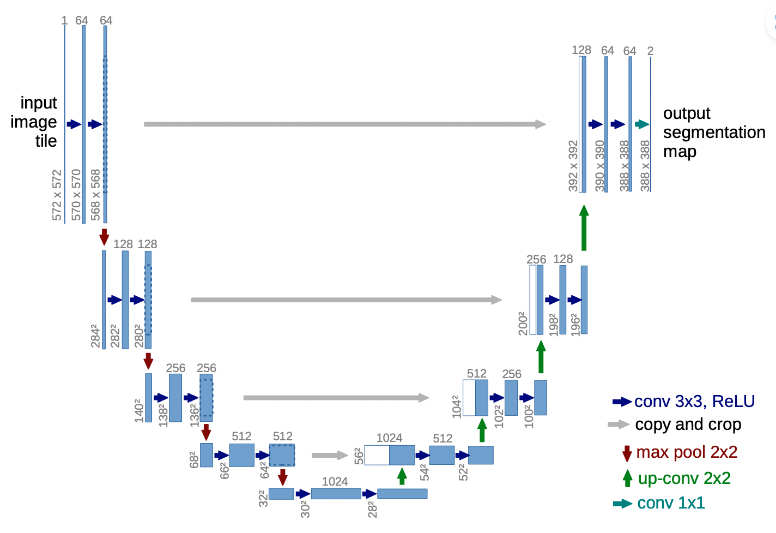

Creating dataframe but excluding Unmasked Concrete Cracks until the number of negative images required to make a balanced dataset is known.
Once this is identified, masks will need to be created before concatenating

In [504]:
# Creating dataframe but excluding dataset "Unmasked Concrete Cracks" until number of negative images are required, and mask are created for that number

df = pd.concat([df_1, df_2, df_3], axis = 0).reset_index(drop = True)
print(f'df shape: {df.shape}')
df.head(2)

df shape: (54184, 9)


Image_File_Path  Img_Height  Img_Width   
0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         227        227  \
1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         227        227   

   Img_AR                                     Mask_File_Path  Mask_Height   
0     1.0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...          227  \
1     1.0  C:\Users\sepeh\OneDrive\Documents\Data\Concret...          227   

   Mask_Width  Mask_AR     Label  
0         227      1.0  POSITIVE  
1         227      1.0  POSITIVE

In [505]:
# Reinspecting dataframe excluding df_deck, pavements, walls
img_height_counts = df['Img_Height'].value_counts()
img_width_counts = df['Img_Width'].value_counts()
img_aspect_ratio_counts = df['Img_AR'].value_counts()

mask_height_counts = df['Mask_Height'].value_counts()
mask_width_counts = df['Mask_Width'].value_counts()
mask_aspect_ratio_counts = df['Mask_AR'].value_counts()

print(f'img_height_counts:\n {img_height_counts}')
print(f'img_width_counts:\n {img_width_counts}')
print(f'img_aspect_ratio_counts:\n {img_aspect_ratio_counts}')
print(f'mask_height_counts:\n {mask_height_counts}')
print(f'mask_width_counts:\n {mask_width_counts}')
print(f'mask_aspect_ratio_counts:\n {mask_aspect_ratio_counts}')
print(f'dataframe_temporary shape: {df.shape}')

img_height_counts:
 Img_Height
227    40000
448    10995
512     3189
Name: count, dtype: int64
img_width_counts:
 Img_Width
227    40000
448    10995
512     3189
Name: count, dtype: int64
img_aspect_ratio_counts:
 Img_AR
1.0    54184
Name: count, dtype: int64
mask_height_counts:
 Mask_Height
227    40000
448    10995
512     3189
Name: count, dtype: int64
mask_width_counts:
 Mask_Width
227    40000
448    10995
512     3189
Name: count, dtype: int64
mask_aspect_ratio_counts:
 Mask_AR
1.0    54184
Name: count, dtype: int64
dataframe_temporary shape: (54184, 9)


The unmasked datasets: df_decks, walls, and pavements will be analyzed for future use when balancing dataset:


In [506]:
# inspecting unamsked dataset for sizes and aspect ratios
unmasked_list = ['df_decks', 'df_walls', 'df_pavements']

for df_name in unmasked_list:
    df = eval(df_name)
    img_height_counts = df['Img_Height'].value_counts()
    img_width_counts = df['Img_Width'].value_counts()
    img_aspect_ratio_counts = df['Img_AR'].value_counts()
    
    print('\n' + df_name + ':\n')
    print(f'img_height_counts: {img_height_counts}')
    print(f'img_width_counts: {img_width_counts}')
    print(f'img_aspect_ratio_counts: {img_aspect_ratio_counts}')



df_decks:

img_height_counts: Img_Height
256    13620
Name: count, dtype: int64
img_width_counts: Img_Width
256    13620
Name: count, dtype: int64
img_aspect_ratio_counts: Img_AR
1.0    13620
Name: count, dtype: int64

df_walls:

img_height_counts: Img_Height
256    24334
Name: count, dtype: int64
img_width_counts: Img_Width
256    24334
Name: count, dtype: int64
img_aspect_ratio_counts: Img_AR
1.0    24334
Name: count, dtype: int64

df_pavements:

img_height_counts: Img_Height
256    24334
Name: count, dtype: int64
img_width_counts: Img_Width
256    24334
Name: count, dtype: int64
img_aspect_ratio_counts: Img_AR
1.0    24334
Name: count, dtype: int64


Analysis:

- it is verified that there are no masks missing from df_1, df_2, and df_3
- there are no 256 pixel images from df_1, df_2, df_3. All will be resized to 256 pixels. This isn't an issue because:
   - it's mostly downsizing with the exception of 227 to 256, which is only a 12% change in upsampling (upsampling is unfavourable)
   - all images are 1:1 aspect ratio
- The unmasked dataset is already 256x256 $pixels^{2}$ and will not require resizing if required for balancing the dataset (as shown next step)

### Inspecting Positive:Negative Ratio

It's important to have a balanced dataset. So we need to inspect the number of positive and negative images

In [507]:
df_positive = df[df['Label'] == 'POSITIVE']
df_negative = df[df['Label'] == 'NEGATIVE']

print(f'Number of positive images: {df_positive.shape[0]}')
print(f'Number of negative images: {df_negative.shape[0]}')
print(f'Number of negative images required: {df_positive.shape[0]- df_negative.shape[0]}')

Number of positive images: 2608
Number of negative images: 21726
Number of negative images required: -19118


This means that there's an imbalance with positive to negative images. If this was a classification problem, then the images would be either Data Augmented or drawn from Unmasked Concrete Crack data folder (for negatives since you can apply just a pure black mask).
However, the purpose of this model is to identify cracks inside a picture and mask it. This, by nature, is an imbalanced dataset where the amount of crack area compared to amount of no-crack area in all the images is much less. 
Because of this, it is actually important to drop negative images in the dataset at first, as they have zero to little crack areas.


AttributeError: 'numpy.int64' object has no attribute 'read'

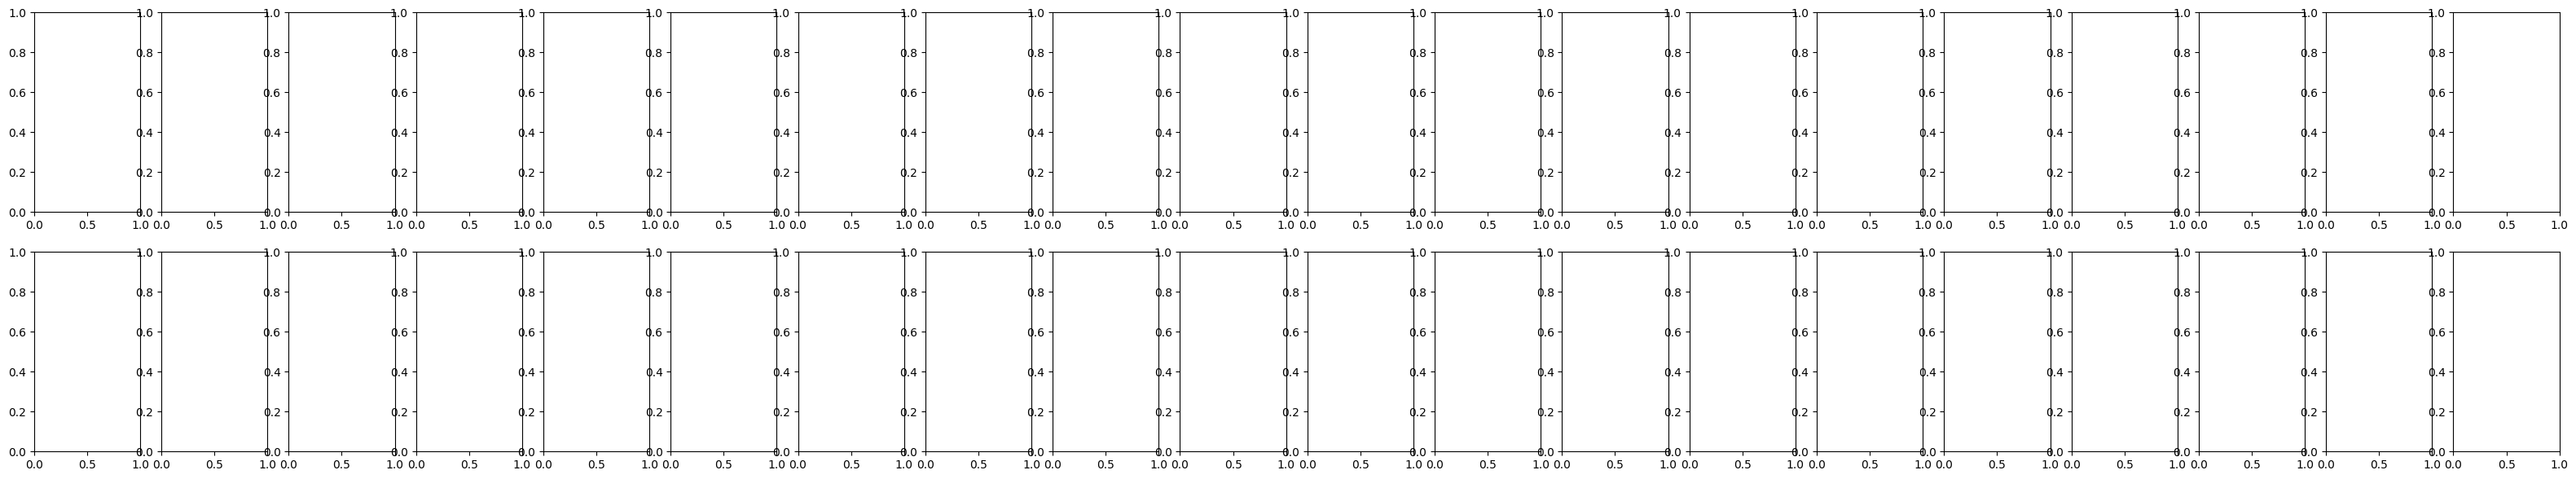

In [509]:
# Inspecting Positive vs Negatives

# creating list of df names
df_list = ['df_positive', 'df_negative']

fig, axs = plt.subplots(nrows=len(df_list), ncols=20, figsize=(40, 7))  # Change ncols to 20
image_data = {}
mask_data = {}  # A dictionary to hold the mask data

for i, df_name in enumerate(df_list):
   for j in range(10):  # Still only picking 10 images
      random_idx = random.randint(0, len(eval(df_name)) - 1)
      image_data[df_name] = Image.open(eval(df_name)['Image_File_Path'].iloc[random_idx])
      mask_data[df_name] = Image.open(eval(df_name)['Mask_File_Path'].iloc[random_idx])  # Open the corresponding mask
      axs[i][2*j].imshow(image_data[df_name])  # Display the image
      axs[i][2*j].axis('off')
      axs[i][2*j].set_title(f"{df_name}, Image {j+1}")
      axs[i][2*j+1].imshow(mask_data[df_name], cmap='gray')  # Display the mask
      axs[i][2*j+1].axis('off')
      axs[i][2*j+1].set_title(f"{df_name}, Mask {j+1}")
      
plt.tight_layout()
plt.show()

The following is observed:
- Negative dataset still can have some defects in it, but the ratio of mask black pixels to white is very large, which contributes to an even more imbalanced dataset
- Postiive cracks are good, but by nature of the datset, there is an imbalance of black:white ratios for the masks

Therefore, 
- As explained previously, Negative:Positive ratio doesn't matter because this is not a classification of concrete presence per image. It is per pixel.
- As such, Negative dataset will be dropped for training. They can be tested on afterwards
- To tackle the imbalance of black:white ratios, a Weighted Loss Function will be tested with, recall score will be utilized

Moving onto Data Wrangling,
- The number of images will be too large, so will downsample first
- Note that images will also be reduced from 256x256 to 64x64 pixels<sup>2</sup>. Once hyperparameterization is complete, then the balanced dataset will be used with 256x256 pixels<sup>2</sup> to run over night
- All data will be carried over in case required later on. Positives can be simply filtered out through the main dataframe

## Data Wrangling

### Sizing to 256x256 & 64x64 pixels<sup>2</sup> <span style="color:red; font-weight:bold;">*(Skippable)*</span>

In [ ]:
df_256 = df.copy()

# Function to resize and save the images in a subfolder called "Resized_256"
def resize_images_256(file_path):
    
    # Extract the root folder path from the file path
    root_folder = os.path.dirname(file_path)
    
    # Set the target folder path for resized images
    resized_folder = os.path.join(root_folder, 'Resized_256')
   
   # Create the target folder if it doesn't exist
    os.makedirs(resized_folder, exist_ok=True)
    
    print(f"Original file path: {file_path}")
    
    # Open the image
    image_new = Image.open(file_path)
    
    # Resize the image if necessary
    if image_new.size != (256, 256):
        image_new = image_new.resize((256, 256))
    
    # Get the file name and extension
    filename = os.path.basename(file_path)
    name, extension = os.path.splitext(filename)
    
    # Create the new file name with _256x256 at the end
    filename_new = f"{name}_256x256{extension}"
    
    # Set the path for the resized image_
    resized_path = os.path.join(resized_folder, filename_new)
    
    # Save the new image
    image_new.save(resized_path)
    
    # Print the resized file path
    print(f"Resized file saved under: {resized_path}")
    
    # Return the resized file path
    return resized_path

In [ ]:
df_64 = df.copy()

# Function to resize and save the images in a subfolder called "Resized_64"
def resize_images_64(file_path):
    
    # Extract the root folder path from the file path
    root_folder = os.path.dirname(file_path)
    
    # Set the target folder path for resized images
    resized_folder = os.path.join(root_folder, 'Resized_64')
   
   # Create the target folder if it doesn't exist
    os.makedirs(resized_folder, exist_ok=True)
    
    print(f"Original file path: {file_path}")
    
    # Open the image
    image_new = Image.open(file_path)
    
    # Resize the image if necessary
    if image_new.size != (64, 64):
        image_new = image_new.resize((64, 64))
    
    # Get the file name and extension
    filename = os.path.basename(file_path)
    name, extension = os.path.splitext(filename)
    
    # Create the new file name with _256x256 at the end
    filename_new = f"{name}_64x64{extension}"
    
    # Set the path for the resized image_
    resized_path = os.path.join(resized_folder, filename_new)
    
    # Save the new image
    image_new.save(resized_path)
    
    # Print the resized file path
    print(f"Resized file saved under: {resized_path}")
        
    # Return the resized file path
    return resized_path

In [ ]:
start_time = time.time()

# Apply the function to each image file path column in the DataFrame. Much faster than iterating through entire dataframe
# Also update the information
df_256['Image_File_Path'] = df['Image_File_Path'].apply(resize_images_256)
df_256['Img_Height'] = 256
df_256['Img_Width'] = 256
df_256['Img_AR'] = 1

df_256['Mask_File_Path'] = df['Mask_File_Path'].apply(resize_images_256)
df_256['Mask_Height'] = 256
df_256['Mask_Width'] = 256
df_256['Mask_AR'] = 1

end_time = time.time()
elapsed_time = end_time - start_time

print(f'\nElapsed time: {elapsed_time/60:.2f} min')

In [ ]:
start_time = time.time()

# Apply the function to each image file path column in the DataFrame. Much faster than iterating through entire dataframe
# Also update the information
df_64['Image_File_Path'] = df['Image_File_Path'].apply(resize_images_64)
df_64['Img_Height'] = 64
df_64['Img_Width'] = 64
df_64['Img_AR'] = 1

df_64['Mask_File_Path'] = df['Mask_File_Path'].apply(resize_images_64)
df_64['Mask_Height'] = 64
df_64['Mask_Width'] = 64
df_64['Mask_AR'] = 1

end_time = time.time()
elapsed_time = end_time - start_time

print(f'\nElapsed time: {elapsed_time/60:.2f} min')

#### Saving new dataframes <span style="color:red; font-weight:bold;">*(Skippable)*</span>

In [ ]:
df_256.to_csv(os.path.join(save_path_256,'df_256.csv'),index=False)
df_64.to_csv(os.path.join(save_path_64,'df_64.csv'),index=False)

## Training & Tuning Model

### Model Selection Explanation

UNET is chosen for its popularity for its effective architecture for image segmenmtation tasks, including masking of concrete cracks. Its 5 major benefits are:

1) It has encoder-decoder architecture, which captures local and global features, making it suitable for concrete crack masking
2) The skip connections in UNet retain spatial information, enabling it to recover fine details and address information loss during downsampling.
3) The U-shape design of UNet allows for learning hierarchical representations at different scales, aiding accurate localization and precise segmentation of concrete cracks.
4) Net effectively fuses features from different levels, enabling it to handle variations in crack size, shape, and texture.
5) UNet performs well with limited training data, making it suitable for concrete crack segmentation even when the labeled dataset is limited.

Its flow diagram can be seen below

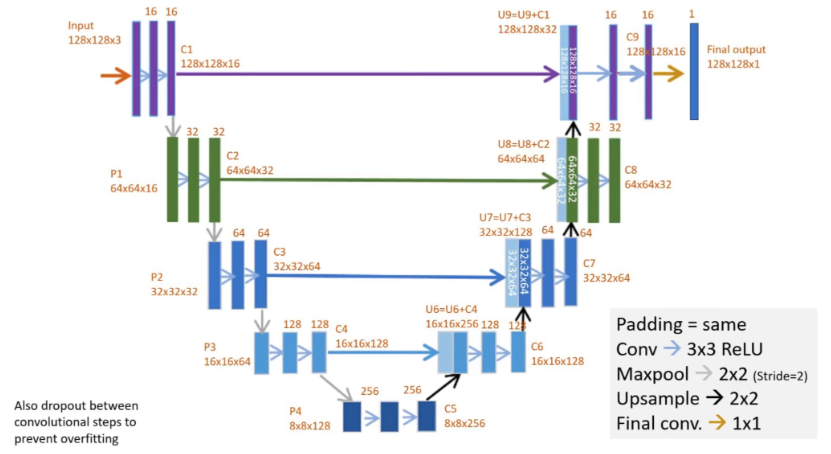

### Parameter Selection Explanation

#### Activation Function

Activation Functions are utilized to introduce non-linearity to a model to enable it to learn complex patterns/
For a UNet model, the following are applicable activiation functions:

1) Sigmoid: Squeezes output between 0 and 1, useful for binary classification problems where output represents a probability
2) Tanh: Similar to sigmoid but maps the output between -1 and 1 using a hyperbolic function, useful for capturing negative values
3) ReLu: Input x returns x if positive, and 0 if negative [=max(0,x])
4) Leaky_ReLu: Modified ReLu which allows small negative values when input is less than 0, instead of minimum = 0. [=max(0.01x,x]. 
5) Elu: Another variation of ReLu that allows negative values and have a smooth curve for negative inputs [=x if x > 0, else alpha * (exp(x) - 1) if x <= 0]. This has a lower computational complexity than batch normalization
6) Swish: New function by Google that is Smooth and non-monotonic that attempts to mitigate problems of ReLu when used on deeper models. However, it is more computationally expensive because of the sigmoid(x) operation. [=x*sigmoid(x)]
7) Softmax: Squashes output values into probability distribution over classes betweenn 0 and 1, with sum of probabilites = 1. Used in final output layer of multi-class classification problems

For this UNet model, ReLu will be used initially due to its established popularity due to its proven performance.
Sigmoid will be used at the final output of the UNet structure because it has the property of mapping any input into a range between 0 and 1, which is required for mask prediction

#### Kernel Initializer

Kernel initializers define the strategy to set the initial random weights of TensorFlow's Keras layers

1) Zeros or Ones: Initializes weights to zero or one - this can lead to problems such as vanishing/exploding gradients during training
2) Constant: Initializes weights to a constant value
3) RandomNormal: Generates tensors with a normal distribution
4) RandomUniform: Generates tensors with a uniform distribution
5) TruncatedNormal: Generates a truncated normal distribution (values more than two standard deviations from the mean are discarded and re-drawn). This is the recommended initializer for neural network weights and filters
6) VarianceScaling: Initializer capable of adapting its scale to the shape of weights
7) Orthogonal: Initializes a tensor with an orthogonal matrix
10) HeNormal: Draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor
11) HeUniform: Draws samples from a uniform distribution within [-limit, limit] where limit is sqrt(6 / fan_in)

However, for this initial UNet model, the "He" initializers are most applicable with ReLu because they are designed to maintain the variance of the inputs through the layers, reducing the issues of vanishing or exploding gradients.

In theory, HeNormal should give slightly more diverse set of initial weights because of it being normally distributed, but both will have to be tested.

#### Optimizer

The optimizer is the method used to adjust the parameters of a model during the training process to minimize the loss function by finding the optimal set of parameter values that results in best performance. Here are a few for Keras:

1) SGD(Stochastic Gradient Descent): It updates the parameters in the direction of negative gradient. This includes options for momentum to dampen oscillation and accelerate convergence, and Nesterov momentum which can make updates more precise. This is the most basic form of optimization algorithm.
2) RMSprop: Restricts oscillations in the vertical direction, enabling faster convergence, by using a moving average of the squared gradient to normalize the gradient itself.
3) Adadelta: Adagrad (optimizer which scales learning rate adaptively for each paramter to perform larger updates for infrequent parameters and smaller updates for frequent parameters) that seeks to reduce its aggressive, monotonically decreasing learning rate to fix the shrinking learning rate of Adagrad.
4) Adam (Adaptive Moment Estimation): Industry default choice for deep learning. It computes adaptive learning rates for different parameters and also stores an exponentially decaying average of past squared gradients like Adadelta and RMSprop.
5) Adamax: Adam with infinity norm.
6) Nadam (Nesterov-accelerated Adaptive Moment Estimation): Adam with Nesterov momentum.
7) AdamW: Adam including weight decay, which can be better for some tasks.

For this image segmentation UNet model, Adam will be selected because it combines the benefits of the two extensionis of stochastic gradient descent AdaGrad and RMSProp. It is also computationally efficient, has little memory requirement which allows lower-end GPUs with less RAM to run, and is well suited for problems that are large in terms of data and parameters.

Other optimizers that can be tested would be RMSprop and SGD with momentum. These might be analyzed

#### Loss Function

1) Mean Squared Error (MSE): Not relevant, *typically used in regression*
2) Mean Absolute Error (MAE): Not relevant, *typically used in regression*
3) Cross-Entropy:
- Versatile loss function often used in classification tasks.
- It measures the dissimilarity between predicted probabilities and true class labels, making it well-suited for multi-class datasets.
- Cross-Entropy has high probability for correct class and low probability for incorrect class.
4) Binary Cross-Entropy (BCE):
- Type of Cross-Entropy designed for binary classification.
5) Dice Coefficient (DICE): 
- Dice loss is defined as 1 minus the Dice coefficient, where the cofficient measures the overlap between predicted and ground truth masks
- Dice loss encourages accurate localization of objects and considers both foreground and background regions.
- It is often used in cases where the foreground class is small compared to the background.

The U-Net crack segmentation model will predict 0 to 1 for whether it sees a crack or not to segment. It rounds anything above a value and assigns it a 1. Therefore, the end data becomes either yes, or no, and therefore Binary Cross-Cross entropy is most relevant.

However, because the dataset is impalanced with having no crack pixels more than all crack pixels, a weighted binary cross-entrop will be explored too

#### Performance Metric

Performance measure used to evaluate the quality of the model.
1) Accuracy: Not a good measure due to imbalanced data
2) Precision: Will result in poor conservative results, it's better to user recall as a safer approach
3) Recall: Great measure used to predict concrete. But needs to be paired up with other scores for validty
4) F1 Score: Combination of Recall and Precision. If both go up, then the recall score is reliable
5) Intersection-Over-Union (IoU), or Jaccard Index: Common method to score iamges with imbalanced data (ie. pixel comparison)

Therefore, recall is a conservative approach and will be used to ensure most cracks are predicted, it will be paired up with f1 score to determine its reliability, and IoU will be looked as well to tackle the imbalanced dataset

### Creating Loss Function & Scoring Metrics

In [461]:
def weighted_binary_crossentropy(y_true, y_pred):
    
    """
    Weighted binary crossentropy between an output tenso and target tensor 

    Args:
      y_true: A binary tensor of shape (batch_size, num_pixels, 1) 
        as ground truth labels.
      y_pred: A binary tensor of shape (batch_size, num_pixels, 1) 
        as predicted labels.

    Returns:
      A scalar tensor as loss.
    """
    
    # will feed into df_history
    global negative_weight, positive_weight
   
    # 1 on each will give standard binary crossentrop    
    negative_weight = float(1) 
    positive_weight = float(1.5)
   
    
    class_weights = tf.constant([negative_weight, positive_weight])

    # Use TensorFlow's binary crossentropy function
    b_ce = tf.keras.losses.BinaryCrossentropy()

    # Calculate the binary crossentropy
    b_ce_loss = b_ce(y_true, y_pred)

    # Apply the weights
    weights = (y_true * class_weights[1]) + ((1. - y_true) * class_weights[0])
    weighted_loss = weights * b_ce_loss

    # Return the mean loss
    return tf.reduce_mean(weighted_loss)
  
  
  
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
# Intersection-Over-Union (IoU), or Jaccard Index
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


### Building Model

#### U-Net 5 Layers

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_29 (Lambda)             (None, 256, 256, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_551 (Conv2D)            (None, 256, 256, 16  1216        ['lambda_29[0][0]']              
                                )                                                                 
                                                                                           

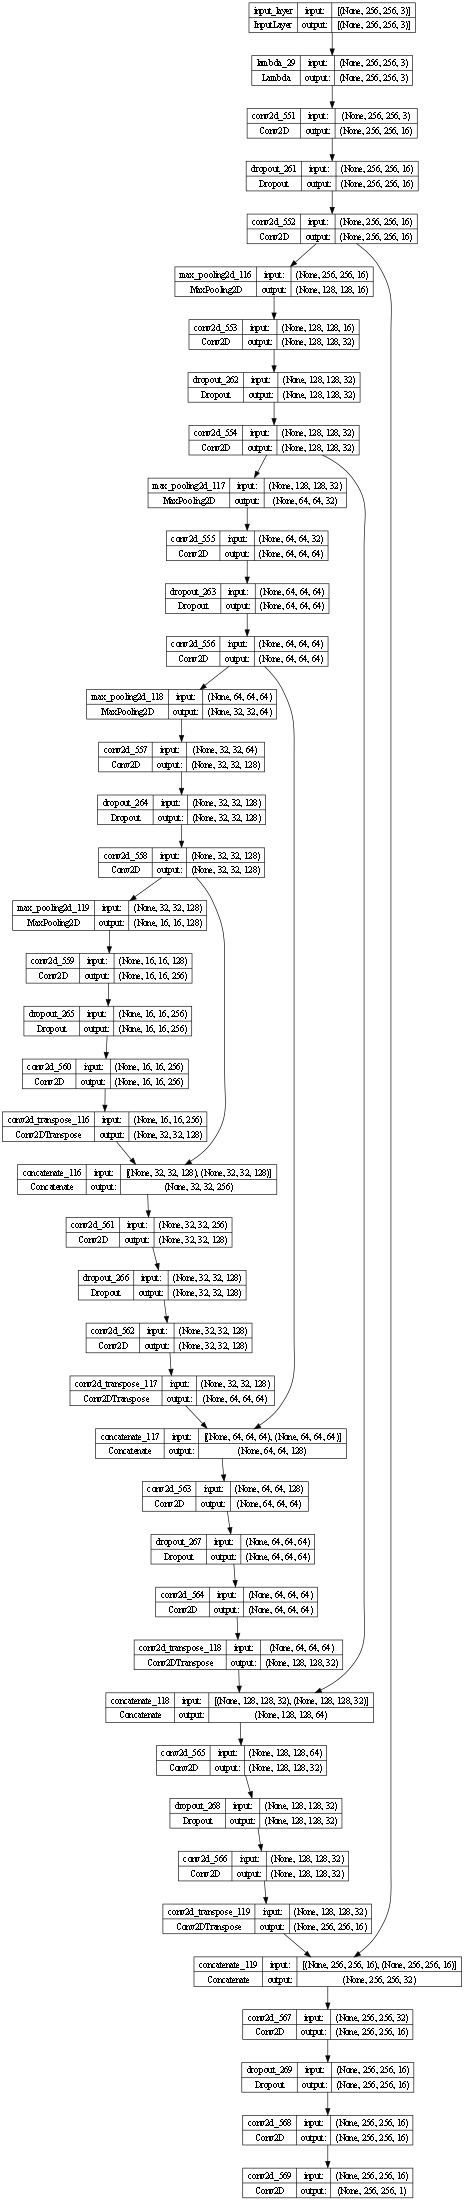

In [352]:
"""""

UNET Model with 5 layers.

Each layer halves the image width and height pixels

Imput image properties and parameters below

"""

# Will feed into df_history
global IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, activation_function 
global kernel_initializer, optimizer, learning_rate, loss_function_str

# Image properties
IMG_WIDTH = int(256)
IMG_HEIGHT = int(256)

IMG_CHANNELS = int(3) #(RGB)

# Input Layer
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name='input_layer')

# activation function 
# Relu is chosen for its simplicity
activation_function = 'relu'

# Starting weights (UNET iteratively improves this)
kernel_initializer = 'he_normal'

# padding = same due to model requirement
padding = 'same'

# Learning rate & Optimizer
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# loss function used to optimize
loss_function = weighted_binary_crossentropy
loss_function_str = "weighted_binary_crossentropy"

# This is the regular python lambda function
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Convolution layers

# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c5)

# Expansive Path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides = (2,2), padding = padding)(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides = (2,2), padding = padding)(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides = (2,2), padding = padding)(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides = (2,2), padding = padding)(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c9)

# Output Layer
outputs = tf.keras.layers.Conv2D(1,(1,1), activation = 'sigmoid')(c9)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
history = unet.compile(
   optimizer=optimizer,
   loss= loss_function,
   metrics=[f1_score, iou_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy']
   )
unet.summary()

# plot
tf.keras.utils.plot_model(unet, "unet.png", show_shapes = True, dpi = 45)

#### U-Net 6 Layers

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_39 (Lambda)             (None, 256, 256, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_777 (Conv2D)            (None, 256, 256, 16  448         ['lambda_39[0][0]']              
                                )                                                                 
                                                                                           

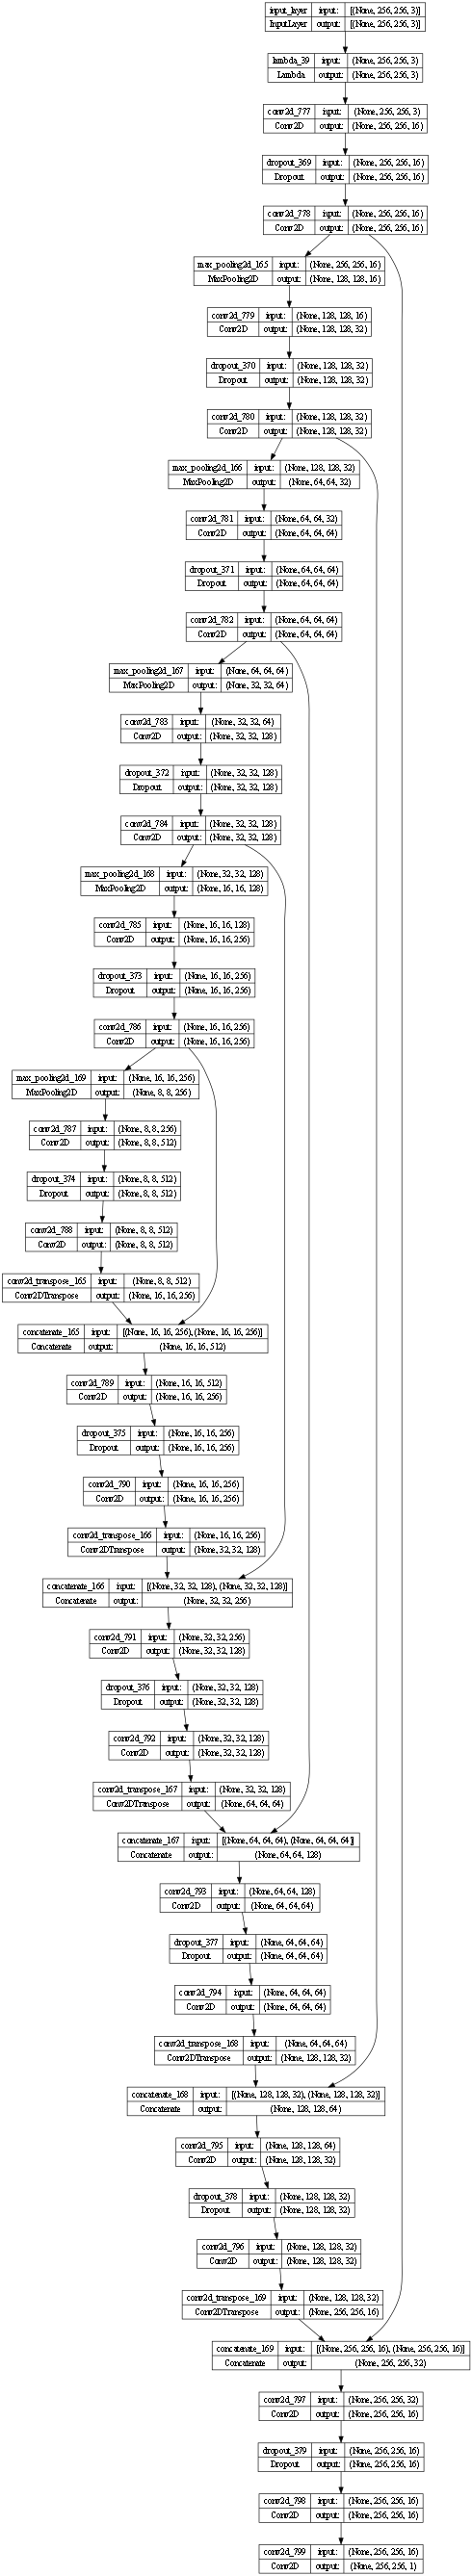

In [494]:
"""""

UNET Model with 6 layers.

Each layer halves the image width and height pixels

Imput image properties and parameters below

"""

# Will feed into df_history
global IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, activation_function 
global kernel_initializer, optimizer, learning_rate, loss_function_str

# Image properties
IMG_WIDTH = int(256)
IMG_HEIGHT = int(256)

IMG_CHANNELS = int(3) #(RGB)

# Input Layer
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name='input_layer')

# activation function 
# Relu is chosen for its simplicity
activation_function = 'relu'

# Starting weights (UNET iteratively improves this)
kernel_initializer = 'he_normal'

# padding = same due to model requirement
padding = 'same'

# Learning rate & Optimizer
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# loss function used to optimize
loss_function = weighted_binary_crossentropy
loss_function_str = "weighted_binary_crossentropy"

# This is the regular python lambda function
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Convolution layers

# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p5)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(512, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c6)

# Expansive Path
u7 = tf.keras.layers.Conv2DTranspose(256,(2,2), strides = (2,2), padding = padding)(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides = (2,2), padding = padding)(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides = (2,2), padding = padding)(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c9)

u10 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides = (2,2), padding = padding)(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u10)
c10 = tf.keras.layers.Dropout(0.2)(c10)
c10 = tf.keras.layers.Conv2D(32,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c10)

u11 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides = (2,2), padding = padding)(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(u11)
c11 = tf.keras.layers.Dropout(0.2)(c11)
c11 = tf.keras.layers.Conv2D(16,(3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c11)

# Create final output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
history = unet.compile(
   optimizer=optimizer,
   loss= loss_function,
   metrics=[f1_score, iou_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy']
   )
unet.summary()

# plot
tf.keras.utils.plot_model(unet, "unet.png", show_shapes = True, dpi = 45)

### U-Net 7 Layers

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_35 (Lambda)             (None, 256, 256, 3)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_685 (Conv2D)            (None, 256, 256, 16  448         ['lambda_35[0][0]']              
                                )                                                                 
                                                                                           

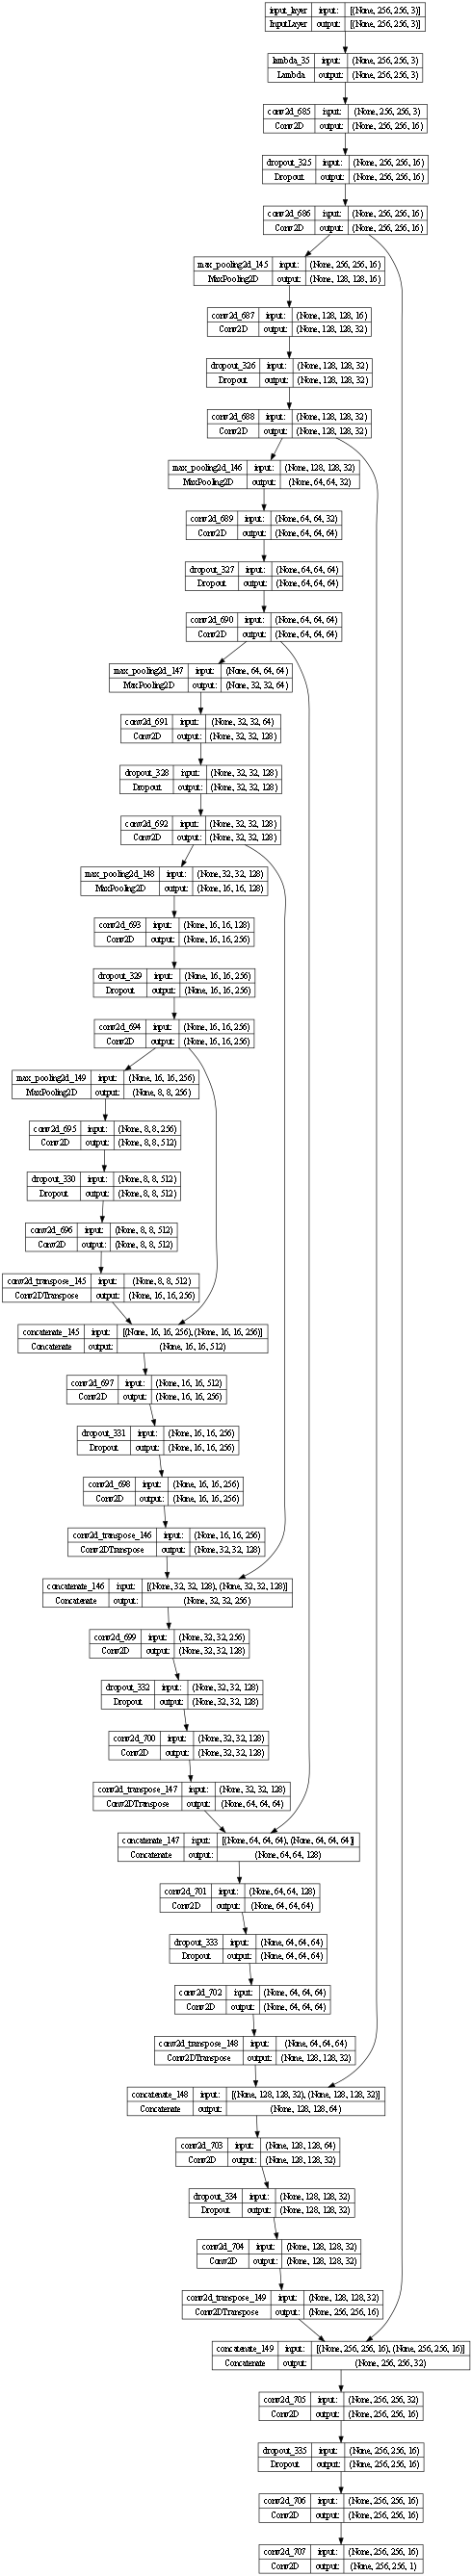

In [473]:
"""""

UNET Model with 7 layers.

Each layer halves the image width and height pixels

Imput image properties and parameters below

"""

# Will feed into df_history
global IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, activation_function 
global kernel_initializer, optimizer, learning_rate, loss_function_str

# Image properties
IMG_WIDTH = int(256)
IMG_HEIGHT = int(256)

IMG_CHANNELS = int(3) #(RGB)

# Input Layer
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), name='input_layer')

# activation function 
# Relu is chosen for its simplicity
activation_function = 'relu'

# Starting weights (UNET iteratively improves this)
kernel_initializer = 'he_normal'

# padding = same due to model requirement
padding = 'same'

# Learning rate & Optimizer
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# loss function used to optimize
loss_function = weighted_binary_crossentropy
loss_function_str = "weighted_binary_crossentropy"

# This is the regular python lambda function
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Convolution layers

# Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = activation_function, kernel_initializer = kernel_initializer, padding = padding)(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

c6 = tf.keras.layers.Conv2D(512, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(p5)
c6 = tf.keras.layers.Dropout(0.1)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c6)

# Expansive Path
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding=padding)(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=padding)(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding=padding)(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                            padding=padding)(c9)

u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding=padding)(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(u10)
c10 = tf.keras.layers.Dropout(0.2)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(c10)

u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding=padding)(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(u11)
c11 = tf.keras.layers.Dropout(0.2)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation=activation_function, kernel_initializer=kernel_initializer,
                             padding=padding)(c11)

# Create final output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])
history = unet.compile(optimizer=optimizer, loss= loss_function, metrics=[f1_score, iou_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), 'accuracy'])
unet.summary()

# plot
tf.keras.utils.plot_model(unet, "unet.png", show_shapes = True, dpi = 45)

### Training Model

##### Importing and Preparing Dataset

Importing Data. Note: no need to run the previous section. Dataframes will be read from the .csv saved

In [8]:
# Importing DataFrames

df_256 = pd.read_csv(os.path.join(save_path_256, 'df_256.csv')).reset_index(drop = True)
df_64 = pd.read_csv(os.path.join(save_path_64, 'df_64.csv')).reset_index(drop = True)

In [9]:
# Shuffling data

df_256 = df_256.sample(frac=1.0, random_state = 1).reset_index(drop=True)
df_64 = df_64.sample(frac=1.0, random_state = 1).reset_index(drop=True)

# Recreating positive/negative dataframes
df_256_positive = df_256[df_256['Label']=='POSITIVE'].reset_index(drop = True)
df_256_negative = df_256[df_256['Label']=='NEGATIVE'].reset_index(drop = True)
df_64_positive = df_64[df_64['Label']=='POSITIVE'].reset_index(drop = True)
df_64_negative = df_64[df_64['Label']=='NEGATIVE'].reset_index(drop = True)

# Verify
df_256_positive

Image_File_Path  Img_Height   
0      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256  \
1      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
2      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
3      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
4      C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
...                                                  ...         ...   
32635  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32636  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32637  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32638  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   
32639  C:\Users\sepeh\OneDrive\Documents\Data\Concret...         256   

       Img_Width  Img_AR                                     Mask_File_Path   
0            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  \
1            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
2            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
3            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
4            256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
...          ...     ...                                                ...   
32635        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32636        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32637        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32638        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   
32639        256       1  C:\Users\sepeh\OneDrive\Documents\Data\Concret...   

       Mask_Height  Mask_Width  Mask_AR     Label  
0              256         256        1  POSITIVE  
1              256         256        1  POSITIVE  
2              256         256        1  POSITIVE  
3              256         256        1  POSITIVE  
4              256         256        1  POSITIVE  
...            ...         ...      ...       ...  
32635          256         256        1  POSITIVE  
32636          256         256        1  POSITIVE  
32637          256         256        1  POSITIVE  
32638          256         256        1  POSITIVE  
32639          256         256        1  POSITIVE  

[32640 rows x 9 columns]

##### Test-Val-Train Splits

In [485]:
# Input of 64x64 images

# sampling size
sample_ratio = 0.99
sample_size = int(len(df_64_positive) * sample_ratio)

# sampling
df_64_positive_sample, df_64_remainder = train_test_split(
    df_64_positive,
    test_size=(1 - sample_ratio),
    # stratify=df_64_positive['Label'],
    shuffle=True,
    random_state=random_state
)

# train/validation and test set
df_64_positive_train_val, df_64_positive_test = train_test_split(
    df_64_positive_sample,
    test_size=0.15,
    # stratify=df_64_positive_sample['Label'],
    shuffle=True,
    random_state=random_state
)

# train and val set
df_64_positive_train, df_64_positive_val = train_test_split(
    df_64_positive_train_val,
    test_size=0.15,
    # stratify=df_64_positive_train_val['Label'],
    shuffle=True,
    random_state=random_state
)

# Removing unnecessary features to decrease potential computational demand. 
drop_columns = ['Img_Height', 'Img_Width', 'Img_AR', 'Mask_Height', 'Mask_Width', 'Mask_AR', 'Label']
df_64_positive_train = df_64_positive_train.drop(df_64_positive_train[drop_columns], axis = 1)
df_64_positive_val = df_64_positive_val.drop(df_64_positive_val[drop_columns], axis = 1)
df_64_positive_test = df_64_positive_test.drop(df_64_positive_test[drop_columns], axis = 1)

# Verify
print(f'Original size: {df_64_positive.shape[0]}')
print(f'Sampled at {sample_ratio}')
print(f'Train size: {df_64_positive_train.shape[0]} ({df_64_positive_train.shape[0]/df_64_positive.shape[0]:0.2f}%)')
print(f'Validation size: {df_64_positive_val.shape[0]} ({df_64_positive_val.shape[0]/df_64_positive.shape[0]:0.2f}%)')
print(f'Test size: {df_64_positive_test.shape[0]} ({df_64_positive_test.shape[0]/df_64_positive.shape[0]:02f}%)')
df_64_positive_train.head(2)

Original size: 32640
Sampled at 0.99
Train size: 23346 (0.72%)
Validation size: 4120 (0.13%)
Test size: 4847 (0.148499%)


Image_File_Path   
30959  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  \
5409   C:\Users\sepeh\OneDrive\Documents\Data\Concret...   

                                          Mask_File_Path  
30959  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
5409   C:\Users\sepeh\OneDrive\Documents\Data\Concret...

In [484]:
# Input of 256x256 images

# sampling size
sample_ratio = 0.99
sample_size = int(len(df_256_positive) * sample_ratio)

# sampling
df_256_positive_sample, df_256_remainder = train_test_split(
    df_256_positive,
    test_size=(1 - sample_ratio),
    # stratify=df_256_positive['Label'],
    shuffle=True,
    random_state=random_state
)

# train/validation and test set
df_256_positive_train_val, df_256_positive_test = train_test_split(
    df_256_positive_sample,
    test_size=0.15,
    # stratify=df_256_positive_sample['Label'],
    shuffle=True,
    random_state=random_state
)

# train and val set
df_256_positive_train, df_256_positive_val = train_test_split(
    df_256_positive_train_val,
    test_size=0.15,
    # stratify=df_256_positive_train_val['Label'],
    shuffle=True,
    random_state=random_state
)

# Removing unnecessary features to decrease potential computational demand. 
drop_columns = ['Img_Height', 'Img_Width', 'Img_AR', 'Mask_Height', 'Mask_Width', 'Mask_AR', 'Label']
df_256_positive_train = df_256_positive_train.drop(df_256_positive_train[drop_columns], axis = 1)
df_256_positive_val = df_256_positive_val.drop(df_256_positive_val[drop_columns], axis = 1)
df_256_positive_test = df_256_positive_test.drop(df_256_positive_test[drop_columns], axis = 1)

# Verify
print(f'Original size: {df_256_positive.shape[0]}')
print(f'Sampled at {sample_ratio}')
print(f'Train size: {df_256_positive_train.shape[0]} ({df_256_positive_train.shape[0]/df_256_positive.shape[0]:0.2f}%)')
print(f'Validation size: {df_256_positive_val.shape[0]} ({df_256_positive_val.shape[0]/df_256_positive.shape[0]:0.2f}%)')
print(f'Test size: {df_256_positive_test.shape[0]} ({df_256_positive_test.shape[0]/df_256_positive.shape[0]:02f}%)')
df_256_positive_train.head(2)

Original size: 32640
Sampled at 0.99
Train size: 23346 (0.72%)
Validation size: 4120 (0.13%)
Test size: 4847 (0.148499%)


Image_File_Path   
30959  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  \
5409   C:\Users\sepeh\OneDrive\Documents\Data\Concret...   

                                          Mask_File_Path  
30959  C:\Users\sepeh\OneDrive\Documents\Data\Concret...  
5409   C:\Users\sepeh\OneDrive\Documents\Data\Concret...

##### Training Model

In [709]:
# generates images to be used in model

def create_data_generator(dataframe, batch_size, shuffle = True):
    while True:
        # Select the indices for a single batch of data
        indices = np.random.choice(dataframe.shape[0], batch_size)
        
        image_batch = []
        mask_batch = []

        for index in indices:
            image_path = dataframe.loc[index, 'Image_File_Path']
            mask_path = dataframe.loc[index, 'Mask_File_Path']

            # Load the image, convert to rgb if applicable, normalize pixel values
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) / 255.0
            # Load the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

            # Convert Greyscale to Binary
            _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            # Normalize binary mask
            binary_mask = binary_mask / 255.0

            image_batch.append(image)
            mask_batch.append(binary_mask)

        yield np.array(image_batch), np.array(mask_batch)
        

# Takes unet.history.history and returns a dataframe with renamed consistent columns for storing

def rename_dataframe_columns(df_history):
    # Convert the history to a DataFrame
    df = pd.DataFrame(df_history)

    # Define a dictionary to map old names to new names
    rename_dict = {}

    # Iterate over the columns in the original DataFrame
    for col in df.columns:
        if 'recall' in col:
            if 'val' in col:
                rename_dict[col] = 'val_recall'
            else:
                rename_dict[col] = 'recall'
        elif 'precision' in col:
            if 'val' in col:
                rename_dict[col] = 'val_precision'
            else:
                rename_dict[col] = 'precision'
        elif 'f1_score' in col:
            if 'val' in col:
                rename_dict[col] = 'val_f1_score'
            else:
                rename_dict[col] = 'f1_score'
        # Add other conditions as needed

    # Rename the columns
    df = df.rename(columns=rename_dict)

    return df

# runs the model and stores information for analysis

def run_model(df_train_selected, df_val_selected, df_test_selected, batch_size = 32, epochs = 15, patience = 3, caption=None):
    
    # count is to record iteration, 
    # df_history is storing model FINAL results
    # def_results is to store tuning parameters and final recall results
    # history_dict is to store history results in categorical fashion to be plotted with a loop
    # generators are for plotting outside function
    
    global count, df_history, df_results_train, history_dict, train_generator,val_generator, test_generator
        
    # Increase and store counter in dictionary
    try:
        count
    except NameError:
      count = 0
    
    count += 1
       
    # Parameters
    batch_size = batch_size
    df_train = df_train_selected.copy().reset_index(drop=True)
    df_val = df_val_selected.copy().reset_index(drop=True)
    df_test = df_test_selected.copy().reset_index(drop=True)

    # Create the data generator
    train_generator = create_data_generator(df_train, batch_size, shuffle = True)
    val_generator = create_data_generator(df_val, batch_size, shuffle = True)
    
    # We want test generator to have 0 shuffle, while train and validation to have shuffle
    test_generator = create_data_generator(df_test, batch_size, shuffle = False)

    # Model Checkpoint directory path
    # checkpoint_filepath = os.path.join(Data_Home, 'Model_Checkpoints', 'Checkpoint')
    checkpoint_filepath = r'C:\Users\sepeh\OneDrive\Downloads'

    # Create if it doesn't exist
    if not os.path.exists(checkpoint_filepath):
        os.makedirs(checkpoint_filepath)

    print(f'Checkpoint Directory: {checkpoint_filepath}')

    # # Initialize the Model Checkpoint callback
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss', # monitors validation loss
        mode='min',
        save_best_only=True)

    # Initialize the Early Stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss', # monitors validation loss
        mode='min',
        patience=patience, # training will be stopped after set# of epochs (patience) if val_loss doesn't improve
        restore_best_weights=True)

    """ 

    Model.fit

    """
    # Train the U-Net model
    history = unet.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=len(df_train) // batch_size,
                    validation_steps=len(df_val) // batch_size,
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback, early_stopping_callback]
                    ) 
    # Callback will stop training if val_loss doesn't improve after set # of epochs (patience)
     
    
    # Create df_history if doesn't exist
    try:
        df_history
    except NameError:
        df_history = pd.DataFrame(columns = ["loss", "f1_score", "iou_coef", "recall", "precision", "accuracy", 
                                             "val_loss", "val_f1_score", 'val_iou_coef', "val_recall", "val_precision",
                                             "val_accuracy", "Run #"])
    
    # New history dataframe is crated from unet.history.history results, and renamed using function
    df_history_new = rename_dataframe_columns(unet.history.history)
    
    # Final Epoch Number
    num_epochs_new = len(df_history_new)
    
    # Append count number to df_history_new
    df_count = pd.DataFrame({'Run #': [count] * num_epochs_new})  
    df_history_new = pd.concat([df_history_new, df_count], axis = 1) 
        
    # New history dataframe is appended to existing dataframe
    df_history_new = df_history_new.reindex(columns=df_history.columns, fill_value=0)  
    
    
    # print(f'\ndf_history_new: {df_history_new}\n')
    # print(f'\ndf_history_new shape: {df_history_new.shape}\n')
    
    df_history = pd.concat([df_history, df_history_new], axis=0, ignore_index=True)
    df_history.reset_index(drop=True, inplace=True)
    
    # print(f'\ndf_history: {df_history}\n')
    # print(f'\ndf_history shape: {df_history.shape}\n')
    
    # Check if history_dict is empty and create it if it is, otherwise do nothing
    try:
        history_dict
    except NameError:
        history_dict = {}
    
     # Store history and caption in dictionary. This will be used to plot performance per tuning iteration
    history_dict["run" + str(count)] = {"history": unet.history.history, "caption": caption}
    
   
    # Final Training Accuracy Score:
    accuracy_score_new = df_history.iloc[-1,5]
    # Final Training Recall Score:
    recall_score_new = df_history.iloc[-1,3]
    # Final Train F1 Score:
    f1_score_new = df_history.iloc[-1,1]
    #  Final IoU Score:
    iou_new = df_history.iloc[-1,2]
    
    # Final Validation Accuracy Score:
    val_accuracy_score_new = df_history.iloc[-1,11]
    # Final Validation Recall Score:
    val_recall_score_new = df_history.iloc[-1,9]
    # Final Validation F1 Score:
    val_f1_score_new = df_history.iloc[-1,7]
    #  Final Validation IoU Score:
    val_iou_new = df_history.iloc[-1,8]
    
    # create df_results the first time to store information
    try:
        df_results_train
    except NameError:
    # Create df
        df_results_train = pd.DataFrame(columns = ["Run #", "Img_Size", "Sample", "Epoch Reached", "Batch", 
                                        "Activation_Function", "Kernel_Initializer", "Optimizer", "Learning_rate", "Loss Function",
                                        "Negative_Weight", "Positive_Weight", "Accuracy Score", "Training Recall Score", 
                                        "Training F1 Score", "Training IoU Score", 'Val Accuracy Score', 
                                        "Val Recall Score", "Val F1 Score", "Val IoU Score","Caption"])

    # Create new row df columns
    df_results_train_new = pd.DataFrame(columns = ["Run #", "Img_Size", "Sample", "Epoch Reached", "Batch", 
                                        "Activation_Function", "Kernel_Initializer", "Optimizer", "Learning_rate", "Loss Function",
                                        "Negative_Weight", "Positive_Weight", "Accuracy Score", "Training Recall Score", 
                                        "Training F1 Score", "Training IoU Score", 'Val Accuracy Score', 
                                        "Val Recall Score", "Val F1 Score", "Val IoU Score","Caption"])


    # Add information to new row df
    df_results_train_new.loc[count-1] = [
                        count, 
                        IMG_WIDTH,
                        sample_ratio, 
                        num_epochs_new,  
                        batch_size,
                        activation_function,  
                        kernel_initializer,  
                        optimizer, 
                        learning_rate,
                        loss_function_str,
                        negative_weight, 
                        positive_weight,
                        accuracy_score_new, 
                        recall_score_new, 
                        f1_score_new,
                        iou_new,
                        val_accuracy_score_new,
                        val_recall_score_new,
                        val_f1_score_new,
                        val_iou_new,
                        caption
                        ]

    df_results_train = pd.concat([df_results_train, df_results_train_new], axis = 0, ignore_index=True)   
    
## Plots predicted images   
def plotImages(images_arr, masks_arr):
    num_images = len(images_arr) * 2  # Each pair consists of 2 images
    num_cols = 10  # Each pair will occupy 2 columns (one for image, one for mask)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows based on images
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4*num_rows), sharex=True, sharey=True)
    
    axes = axes.ravel()  # Flatten axes for easy indexing
    
    for i in range(len(images_arr)):
        axes[2*i].imshow(images_arr[i])
        axes[2*i].axis('off')
        axes[2*i].set_title('Image')
        
        axes[2*i+1].imshow(masks_arr[i], cmap='gray')
        axes[2*i+1].axis('off')
        axes[2*i+1].set_title('Mask')
        
    # Turn off axes for remaining empty subplots
    for j in range(num_images, num_rows*num_cols):
        fig.delaxes(axes[j])
        
    # Adjust the spacing between rows
    plt.subplots_adjust(hspace=-0.8)   
    
# Used to split texts into multiple lines for readability
def split_text(text, length):
    return '\n'.join(text[i:i+length] for i in range(0, len(text), length))

# Used to plot validation and train scores and loss
def plot_results (start, end):
    
    # Figure size
    plt.figure(figsize=(12.5, 3 * count))

    # a counter to mark the plot index
    plot_number = 1 

    # List of columns to plot
    columns_to_plot = [['loss', 'val_loss'], 
                    ['recall','f1_score','val_f1_score', 'val_recall'], 
                    ['iou_coef', 'val_iou_coef']]

    # list of y labels to plot
    y_labels_to_plot = ['Loss', 'Score', 'IoU']

    # List of columns to print the plot
    columns_to_print = ['Training Recall Score', 'Training F1 Score', 'Training IoU Score', 
                        'Val Recall Score', 'Val F1 Score', 'Val IoU Score','Caption']

    for run_number in range(start, end+1):
        
        # Set up row title to plot
        titles_to_plot = ['Model loss for Run #' + str(run_number),
                        'Model Recall and F1 Score for Run #' + str(run_number),
                        'Model IoU for Run #' + str(run_number)]
        
        # Get the metrics data to plot
        df_plot = df_history[df_history['Run #'] == run_number]
        
        # Set x-ticks to represent the number of epochs
        num_of_epochs = df_plot.shape[0]
            
        # Get the row caption data to plot
        run_caption = df_results_train[df_results_train['Run #']==run_number]['Caption'].values[0]
                        
        for i in range(0,3):
        
            # Select the subplot position
            plt.subplot(count, 3,plot_number)
                        
            # Plot columns_to_plot
            plt.plot(range(num_of_epochs), df_plot[columns_to_plot[i]])
            plt.title(titles_to_plot[i])
            plt.xlabel('Epoch')
            plt.ylabel(y_labels_to_plot[i])
            plt.legend(columns_to_plot[i],loc= 'upper left')
            plt.text(0.5,0.3, split_text(run_caption, 40),
                    horizontalalignment = 'center',
                    verticalalignment = 'center',
                    transform=plt.gca().transAxes)
            plt.xticks(range(0,num_of_epochs))
                    
            # Increase index counter
            plot_number += 1

        ## ONLY ACTIVATES ON MOST RECENT RESULTS
        if count - run_number == 1 :
            
            for i in range(0,6):
                
                # scoring metrics difference
                scores_old = df_results_train[df_results_train['Run #'] == run_number-1][columns_to_print[i]].values[0]
                scores_recent = df_results_train[df_results_train['Run #'] == count][columns_to_print[i]].values[0]
                scores_difference =  scores_recent - scores_old
                
                # print the difference between the last two iteration scores
                print(f'{columns_to_print[i]} changed by: {scores_difference:0.3f}')
            
            # Number of epochs:
            num_epochs = len(df_history[df_history['Run #']==count])
            # Print the number of epochs
            print(f'Number of epochs for Run # {count}: {num_epochs}')

            # Caption for latest results:
                # Get the row caption data to plot
            run_caption_recent = df_results_train[df_results_train['Run #']==count]['Caption'].values[0]
            # Print the caption or comment for the run
            print(f'Comments for Run #{run_number}: {run_caption_recent}\n')
        
    # Show the plot
    plt.tight_layout()
    plt.show()

### Tuning Model *(Iteratable)*

To reset Loop in case of forgetting to put tuning parameters in caption before running:

In [711]:
# delete_list = ['count', 'history_dict', 'df_history', 'df_results_train']
# for var_name in delete_list:
#    del globals()[var_name]

# df_history = df_history[df_history['Run #'] != 16]
# df_results_train = df_results_train[df_results_train['Run #'] != 16]

In [495]:
"""
Note that save file for recall (to stop unecessary epoch iterations )is noted in the function 'run_model'
"""

# Parameters
batch_size = 10 # number of samples that are processed before model is updated
epochs = 30 # maximum number of complete passes through training dataset
patience = 3 # number of epochs required to stop training if val_loss doesn't improve

# dataframes required:
df_train_selected = df_256_positive_train
df_val_selected = df_256_positive_val
df_test_selected = df_256_positive_test

# record changes made to dictionary:
caption = '256x256, Sample: 0.99, Batch: 10, bin_crossentropy(1,1.5), ReLu, he_norm, adam=0.001, 6 layers, kernel(3,3)'

# Run model
run_model(df_train_selected, df_val_selected, df_test_selected, batch_size, epochs, patience, caption)

Checkpoint Directory: C:\Users\sepeh\OneDrive\Downloads
Epoch 1/30
2334/2334 [==============================] - 367s 156ms/step - loss: 0.8725 - f1_score: 4.7841e-05 - iou_coef: 1.5157e-04 - recall_39: 6.1216e-05 - precision_39: 0.0590 - accuracy: 0.9449 - val_loss: 0.8645 - val_f1_score: 0.0000e+00 - val_iou_coef: 2.9822e-05 - val_recall_39: 0.0000e+00 - val_precision_39: 0.0000e+00 - val_accuracy: 0.9455
Epoch 2/30
2334/2334 [==============================] - 345s 148ms/step - loss: 0.8800 - f1_score: 1.9805e-08 - iou_coef: 2.9639e-05 - recall_39: 1.1800e-08 - precision_39: 0.0769 - accuracy: 0.9446 - val_loss: 0.8612 - val_f1_score: 0.0000e+00 - val_iou_coef: 2.9964e-05 - val_recall_39: 0.0000e+00 - val_precision_39: 0.0000e+00 - val_accuracy: 0.9457
Epoch 3/30
2334/2334 [==============================] - 342s 147ms/step - loss: 0.8748 - f1_score: 2.6036e-08 - iou_coef: 2.9648e-05 - recall_39: 1.1866e-08 - precision_39: 0.0909 - accuracy: 0.9449 - val_loss: 0.8660 - val_f1_score: 0.

#### U-Net Model Evaluation

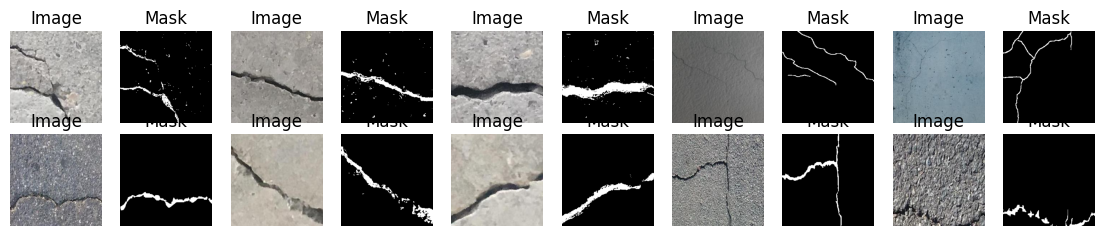

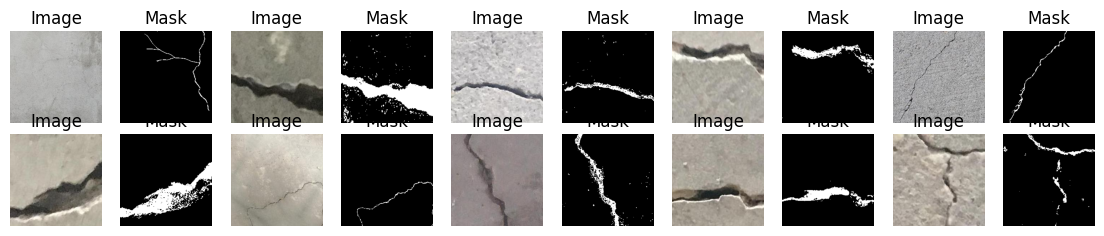

In [708]:
# Generate a batch of images and masks from the train_generator
imgs, masks = next(train_generator)
# Plot the images and masks
plotImages(imgs, masks)
# Generate a batch of images and masks from the val_generation
val_imgs, val_masks = next(val_generator)
# Plot the images and masks
plotImages(val_imgs, val_masks)

<Axes: >

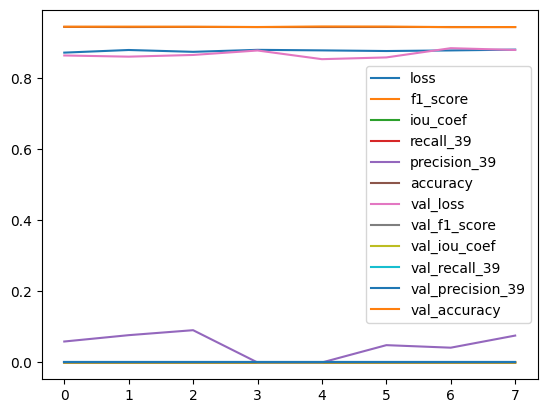

In [712]:
# Plot most recent results
pd.DataFrame(unet.history.history).plot()

### Run # Plots 1-10

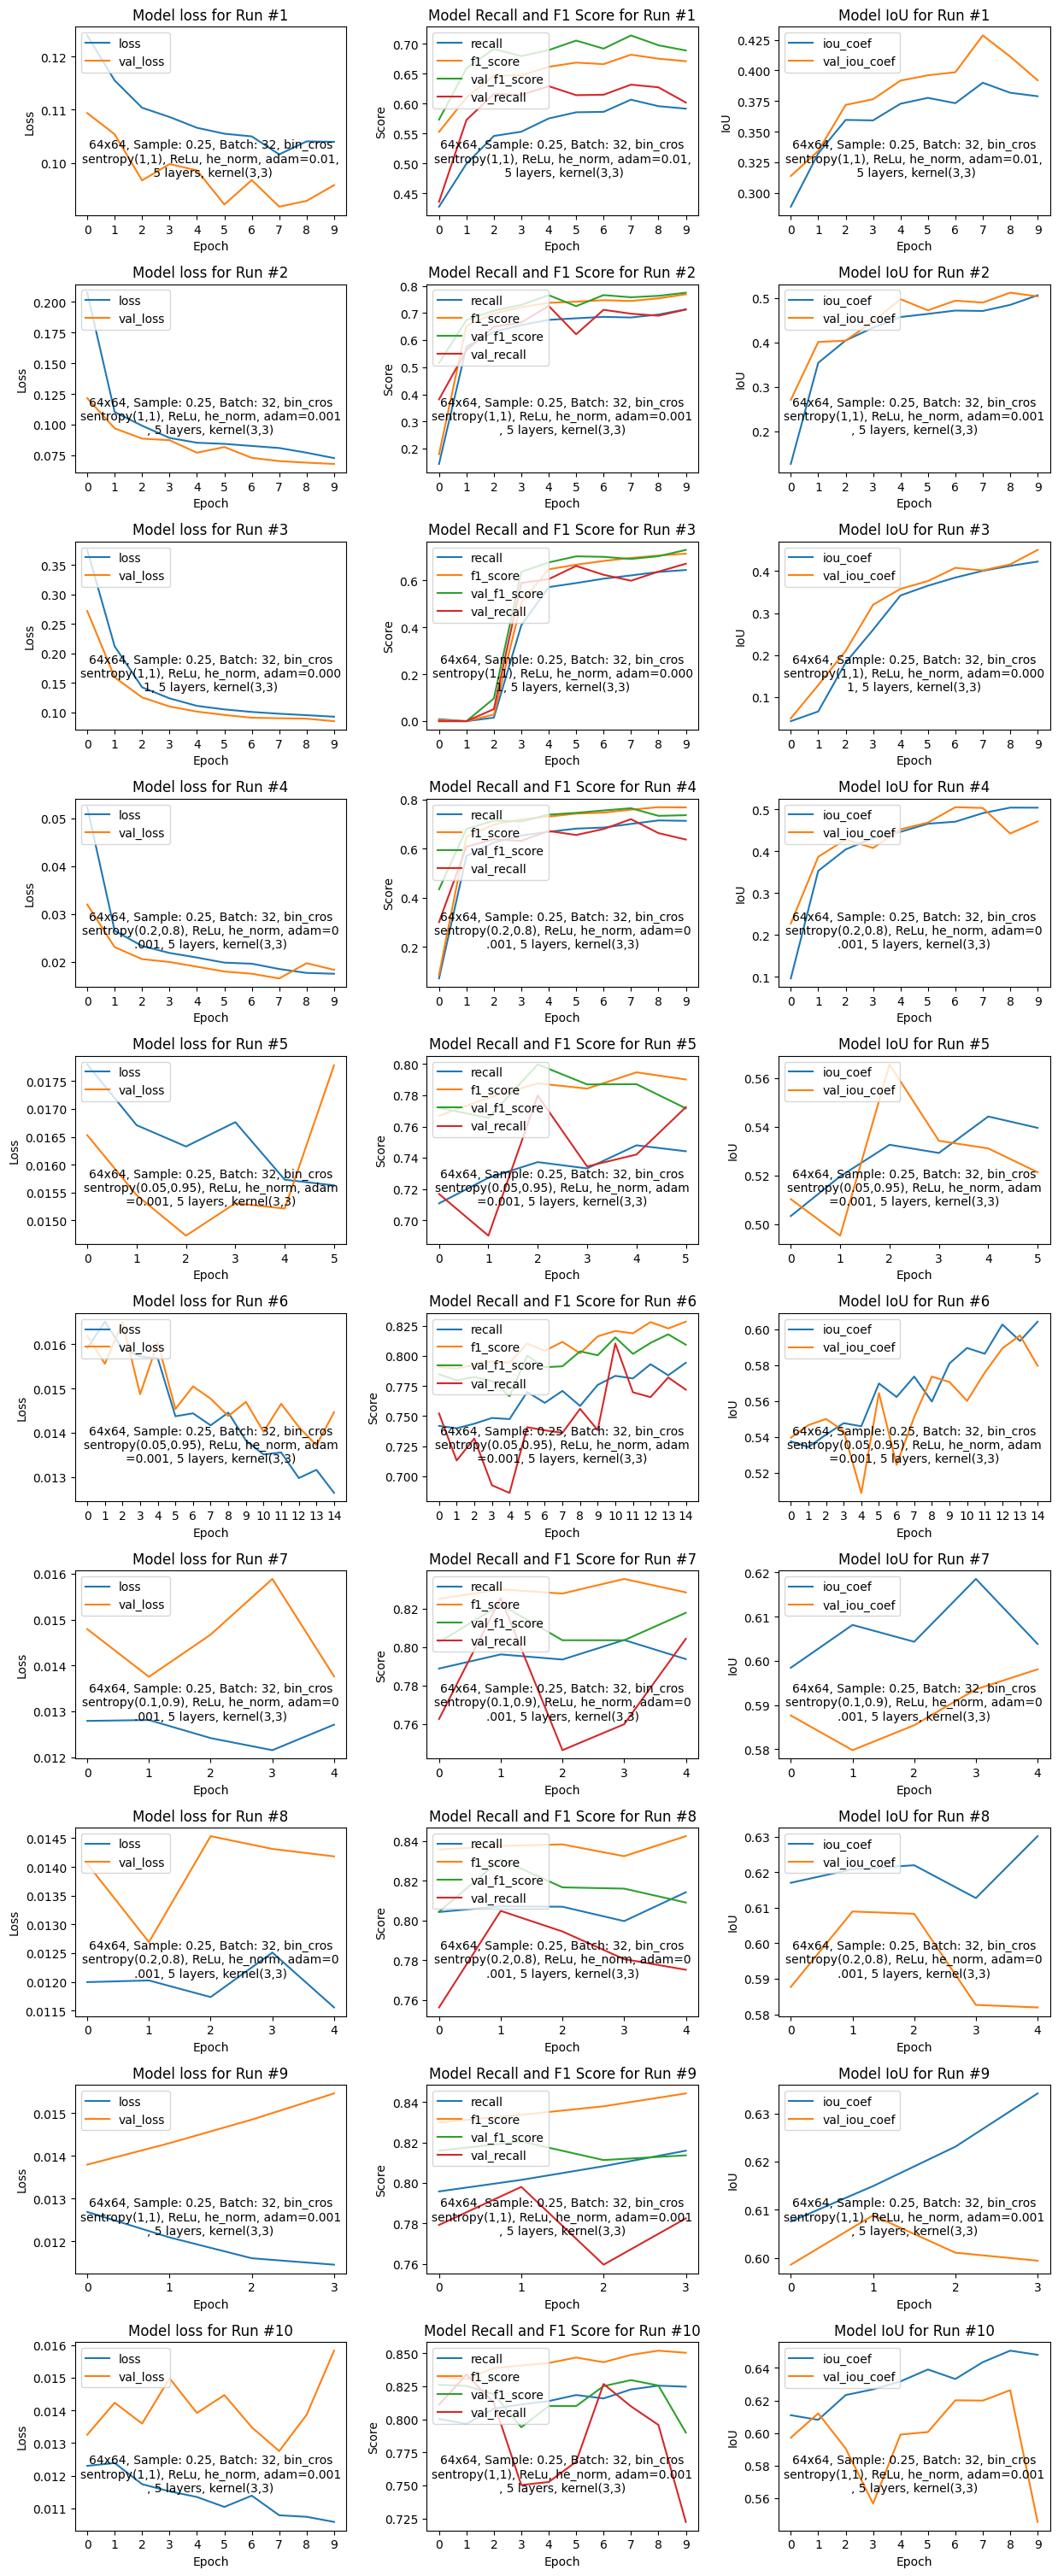

In [710]:
plot_results(1,10)

### Run # Plots 11-26

Training Recall Score changed by: -0.793
Training F1 Score changed by: -0.816
Training IoU Score changed by: -0.586
Val Recall Score changed by: -0.754
Val F1 Score changed by: -0.806
Val IoU Score changed by: -0.577
Number of epochs for Run # 26: 8
Comments for Run #25: 256x256, Sample: 0.99, Batch: 10, bin_crossentropy(1,1.5), ReLu, he_norm, adam=0.001, 6 layers, kernel(3,3)



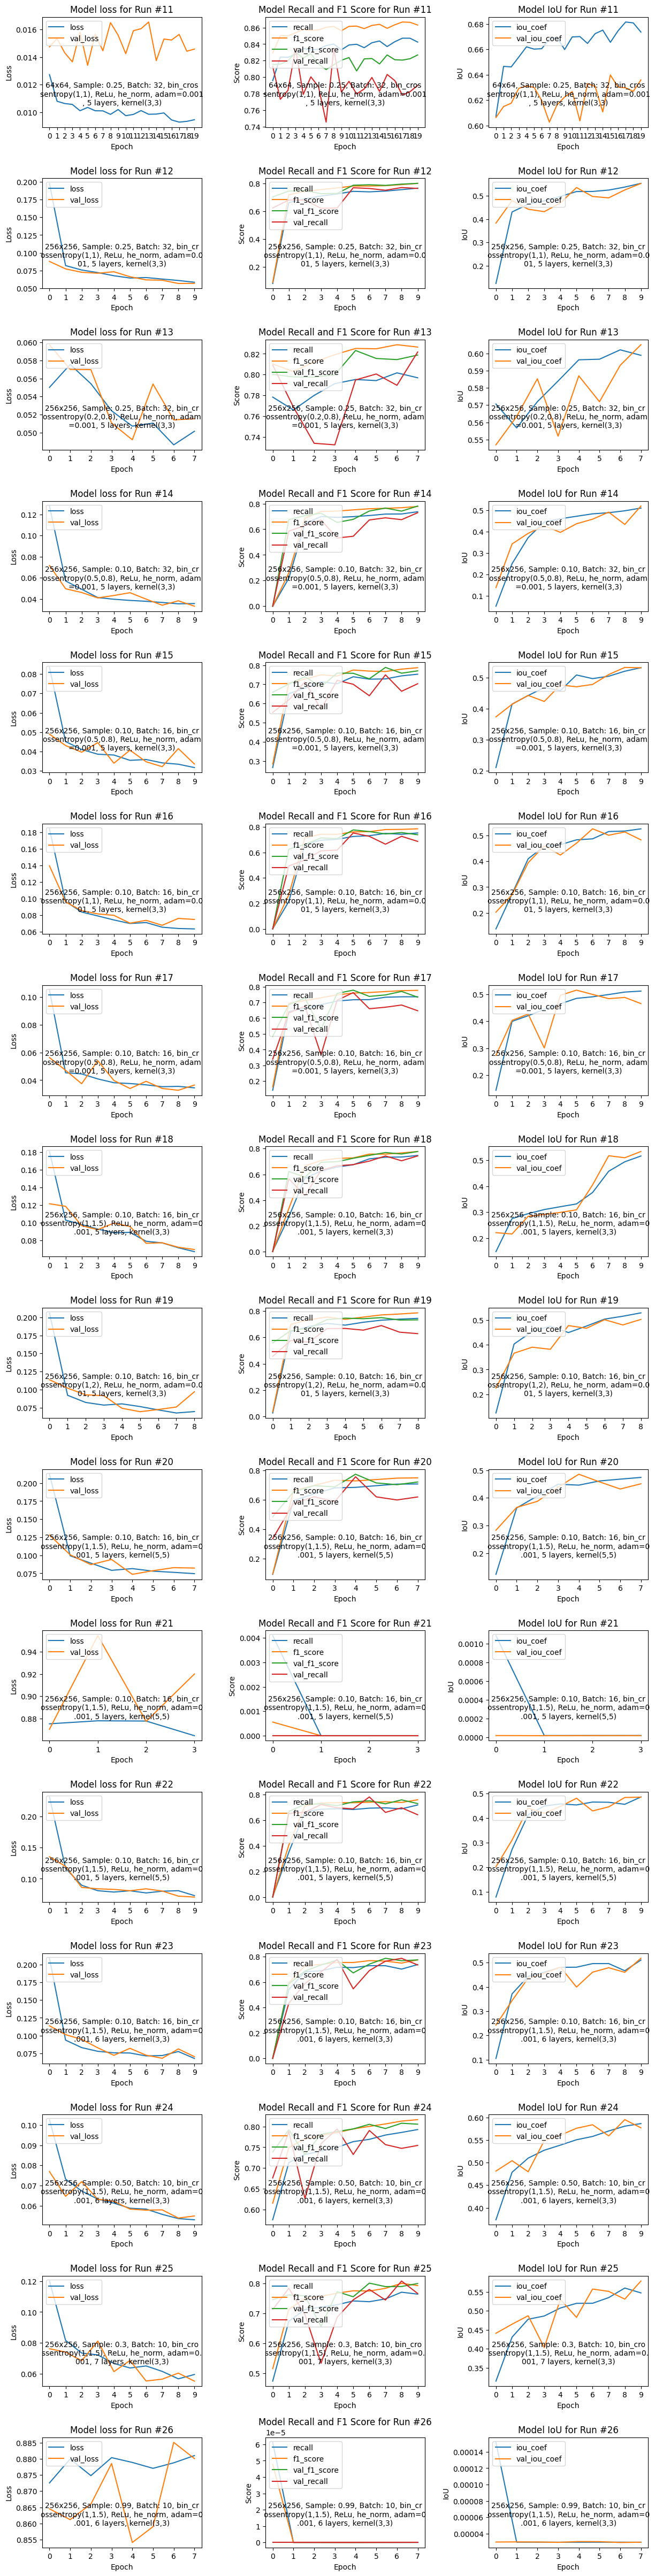

In [698]:
plot_results(11,count)

### Final Scores per Run #

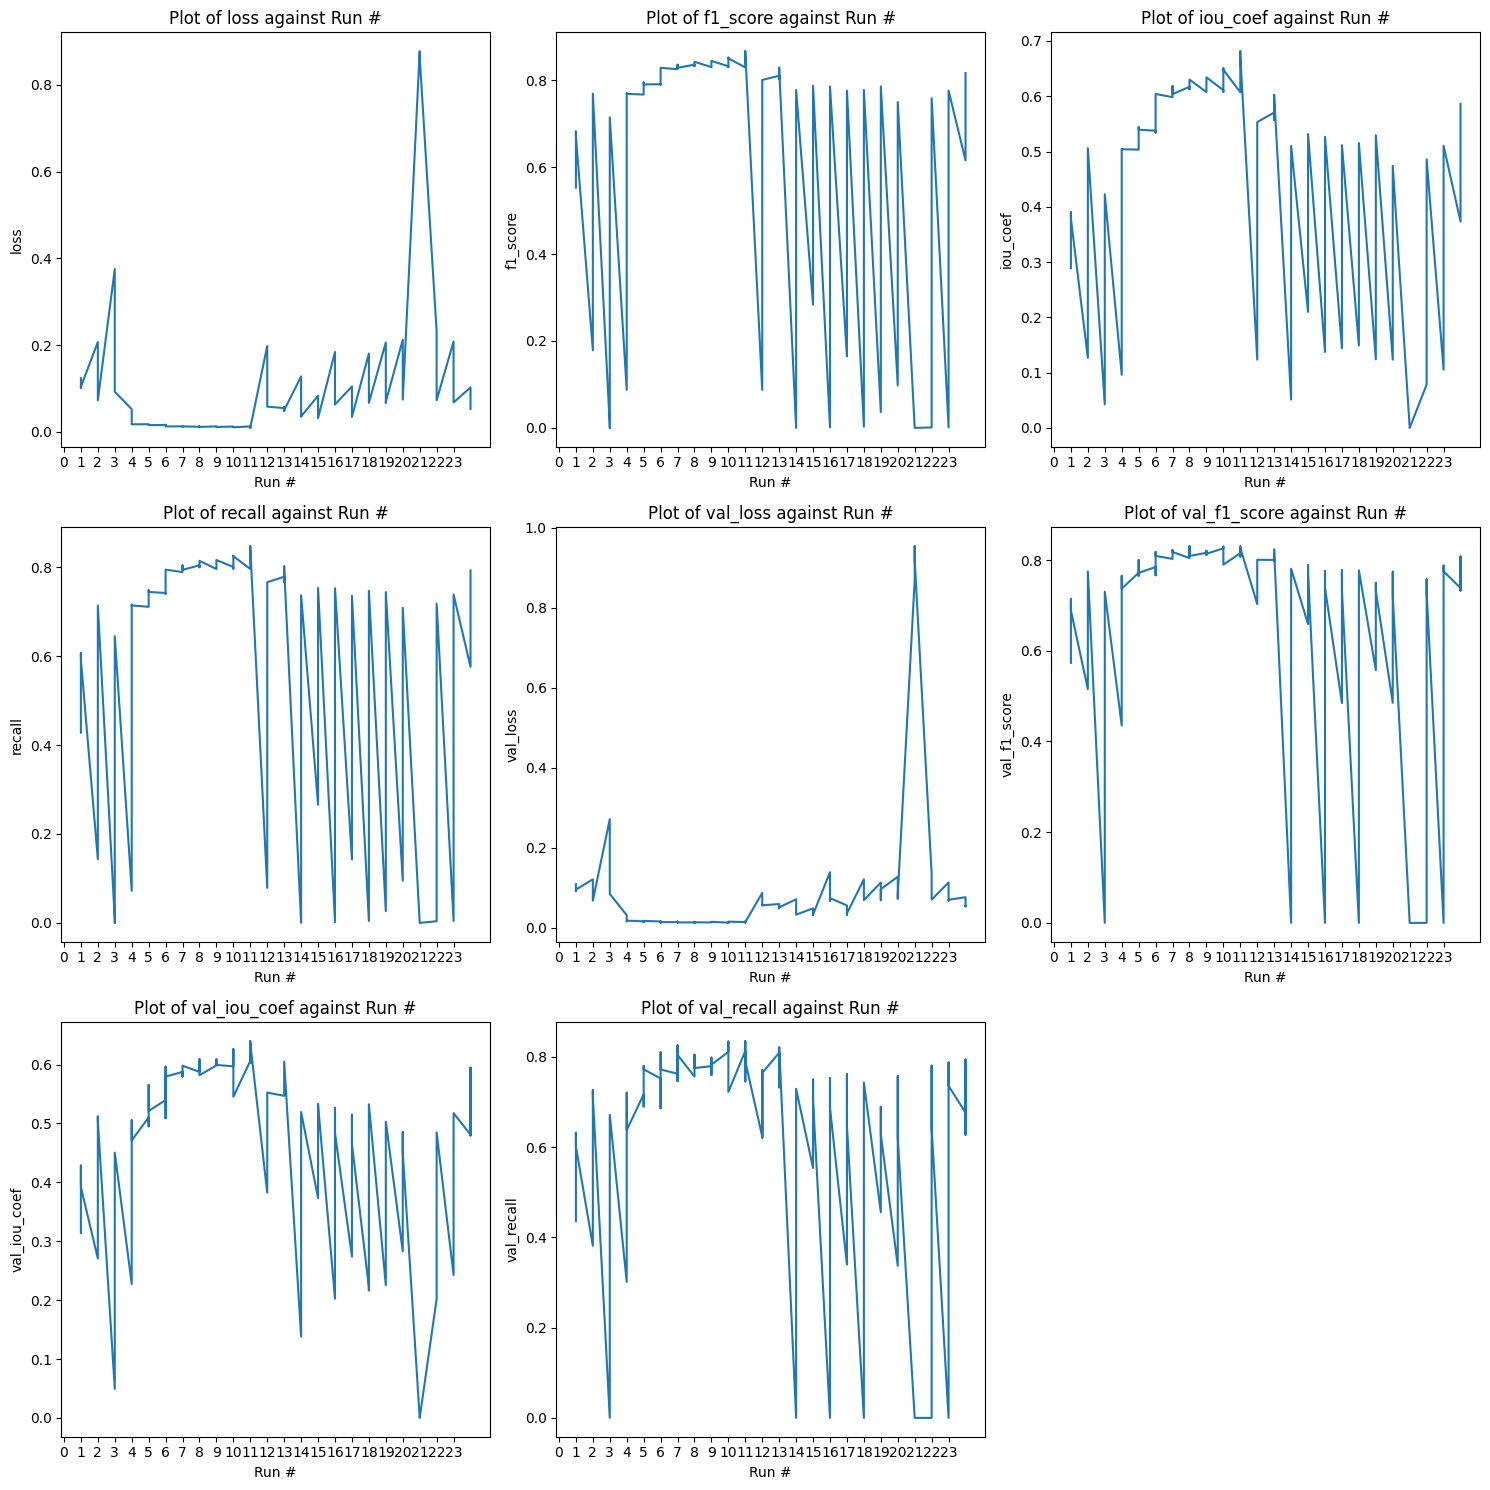

In [458]:
# List of columns to plot
columns_to_plot = ['loss', 'f1_score', 'iou_coef', 'recall',
                   'val_loss', 'val_f1_score', 'val_iou_coef', 'val_recall']

# Calculate the number of rows and columns for the subplots
num_plots = len(columns_to_plot)
num_rows = (num_plots + 2) // 3
num_cols = min(3, num_plots)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()

# Plot each column in a subplot
for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(df_history['Run #'], df_history[column])
    ax.set_title('Plot of ' + column + ' against Run #')
    ax.set_xlabel('Run #')
    ax.set_ylabel(column)
    ax.set_xticks(range(df_history['Run #'].max()))

# Hide empty subplots
for j in range(num_plots, num_rows*num_cols):
    fig.delaxes(axes[j])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

### Tuning Process Documentation

1) 64x64, Sample: 0.25, Batch: 32, bin_crossentropy(1,1), ReLu, he_norm, adam=0.01, 5 layers, kernel(3,3).
2) Decreased learning rate to 0.001
3) Great improvement. Decreased to 0.0001 to see if it improves more
4) Decreased in performance. Reseting to 0.001. Adding 0.2 negative weight, 0.8 positive weight
5) Performance slightly improved. Adding 0.05 negative weight, 0.95 postive wieght
6) Did not converge. Running with epoch = 15
7) Weights prevent consistent convergence. Making weights 1 and 0.9. Chaging epoch back to 10
8) early low loss. Reverting weights to 0.2 and 0.8
9) Scores are not convering but loss is convering early. Reverting weights to 1 and 1 to see if this is fixed.
10) Removed callback stopping epoch at 3. Rerunning
11) Still not converging and val_loss increasing. Will increase epoch to 20 and see if it converges.
12) This data is a concern - resolution might be too small to allow for proper prediction, switching to 256x256 with epoch 10
13) Drastic improvements. Adding callback for val_min with patience 3 to stop earlier if applicable. Adding weights 0.2 and 0.8.
14) Scores increased but convergence is not convincing. Changing weights to 0.5,0.8. Reducing sample to 10% since GPU crashing
15) Performance slightly decreased but sample was drasticly cut by more than half. Will rerun with batch size = 16 to prevent crashes
16) Now will change weights back to 1,1
17) Will revert back to 0.5, 0.8 weights.
18) Weights reduced performance. Will try 1,1.5 one more time, a drastic increase difference to analyze performance.
19) There were differences. Making weights 1,2
20) Reverting back to 1,1.5. Increasing kernal to 5,5
21) Performance dropped in all regards. Will try one more time, same parameters
22) Plummeted to 0. Will rerun
23) Confirmed that (5,5) kernel decreases performance so reverting back to (3,3). Because an image has a center, kernel is preferred to be odd. Increasing to 6 layers
24) Performance did improve, but at a large computational cost. Will push the limits with sample size increasing it to 0.5. Batch down to 10
25) There was an imporvement, but not worth the huge amount of computational power. Will decrease sample size to 0.3 and instead increase layer to 7
26) No improvement for layer 7. Going back to layer 6. Sample size = 0.99. Epoch = 30

Conclusion:

- After some analysis, research and consultation, the approach to tuning will be modified. 
- A few take aways are: 
   - Do not change sample size. Stay consistent to keep the same training set
   - Need to look into what stratify even means with splitting this type of data. But have kept it active
   - A lot of the results that were considered poor just needed more epochs to converge
   - The focus should be on training and validation loss at first. This is to prevent over and underfitting
- The rest of the training will be done in "UNET_Model.ipynb"